# To do
Tournament selection

Subtree mutation

Ramped half and half initialisation

Blpat control (max depth)

Solution saving as checkpoint


Pedestrian dataset

In [1]:
#Libraries
import random as rd
import math
import numpy as np
import operator
import copy
import matplotlib.pyplot as plt
import pylab as py
from collections import defaultdict
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure
import time
from sklearn.preprocessing import StandardScaler

In [2]:
#Global variables
Logs = True
save_plots = False

In [23]:
#Function tools
def feature_extractor(image, box_size = 6, stride = 6, ignore_borders = 2):
    """Receives a numpy matrix as image, returns mean and standard deviation for every squared box in a list"""
    image = np.array(image)
    features = []
    if ignore_borders > 0:
        image = image[ ignore_borders : -ignore_borders , ignore_borders : -ignore_borders]
    horizontal_jumps = int((image.shape[0] - box_size) / stride)
    vertical_jumps = int((image.shape[1] - box_size) / stride)
    for i in range(vertical_jumps):
        for j in range(horizontal_jumps):
            vertical_start = j * stride
            horizontal_start = i * stride
            box = image[ vertical_start : vertical_start + box_size , horizontal_start : horizontal_start + box_size]
            features.append(np.mean(box))
            features.append(np.std(box))
    return np.array(features)
    
def safe_divide(a, b):
    """This function provides a 'safe' division for two numbers. If the denominator b
    is 0, the function will return a"""
    if b == 0 :
        return a
    else:
        return a/b
    
def signed_if(a, b, c):
    """This function works as an if which interprets the first argument 'a' as False if negative
    and returns 'b', else 'c'"""
    if a < 0 :
        return b
    else:
        return c

In [4]:
class SymbollicTreeFunction:
    def __init__(
            self,
            features,
            evaluate_fitness_f,
            max_initial_depth = 3):
        """
        Arguments:
            features: number of features the tree will expect
            dimensions: sample dimensions or features amount
            max_initial_depth: restricts depth of generated functions in their tree representation.
        """
        self.features = features
        self.evaluate_fitness_f = evaluate_fitness_f
        self.max_initial_depth = max_initial_depth 
    
    def generate_terminal(self):
        """features is the amount of features available for each sample, as an int"""
        #global variable: dimensions
        is_constant = False
        value = rd.randint(0, self.features)
        if value == self.features:
            is_constant = True
            value = np.random.uniform()
        return value
        
    def _generate_individual(self, parent=None, depth=0): #OK
        """Generate an individual within the initial population."""
        if depth == self.max_initial_depth:
            terminal = self.generate_terminal()
            return Node(terminal, parent, None, None)
        else:
            node = Node(self._generate_operator(), parent, None, None)
            node.left_child = self._generate_individual(parent=node, depth=depth+1)
            node.right_child = self._generate_individual(parent=node, depth=depth+1)
            return node
    
    def _generate_operator(self): #OK. To do: add if
        """Generate an operator. Operators can be '+','-','*' or '/'. This function is used for generating
        individuals in the initial population (_generate_individual) and for generating new trees during the mutation process
        (_mutate_tree)."""
        return rd.choice([operator.add, operator.sub, operator.mul, safe_divide])
    
    def evaluate(self, population):
        """This function evaluates the fitness of one individual."""
        evaluations = self.evaluate_fitness_f(population)
        return evaluations
    
    def _crossover(self, probabilities, amount):
        """Create a crossover randomly chosen individuals. Probabilities is a tuple of lists of the functions of the individuals and
        their corresponding scaled fitness score. The variable 'amount' defines how many crossovers are created."""
        new_individuals = []
        first_parents = self._sample_population(probabilities, amount)
        second_parents = self._sample_population(probabilities, amount)
        for first_parent, second_parent in zip(first_parents, second_parents):
            new_individuals.append(self._crossover_trees(first_parent, second_parent))
        return new_individuals
    
    def _sample_population(self, probabilities, amount):
        """Choose individuals randomly. Individuals with a lower fitness score (a lower error) are more likely to be 
        chosen. Probabilities is a tuple of lists of the functions of the individuals and their corresponding scaled 
        fitness score. The variable 'amount' defines how many crossovers are created."""
        population, weights = zip(*probabilities)
        return rd.choices(population=population,weights=weights,k=amount)
    
    def _collect_nodes(self, root_node):
        """Function to get a list of the nodes in one tree. Used in _mutate_tree and _crossover_trees."""
        nodes = [root_node]
        i = 0
        while i < len(nodes):
            if not nodes[i].is_terminal():
                nodes.append(nodes[i].left_child)
                nodes.append(nodes[i].right_child)
            i += 1
        return nodes
    
    def mutate(self, parent):
        """This function mutates one parent. A mutation point is chosen randomly among all nodes. The tree is mutated
        at that point by changing the node at that mutation point."""
        new_tree = parent.copy()
        nodes = self._collect_nodes(new_tree)
        mutation_point = rd.choice(nodes)
        if mutation_point.is_terminal():
            mutation_point.content = self.generate_terminal()
        else:
            mutation_point.content = self._generate_operator()
        return new_tree
    
    def _crossover_trees(self, first_parent, second_parent):
        """This function creates a crossover of two given parent trees. It chooses the node, which will be overwritten,
        in the first parent and the crossover section, the node of the first parent will be overwritten with, from the
        second parent. It returns the new individual of that crossover."""
        second_nodes = self._collect_nodes(second_parent)
        crossover_section = rd.choice(second_nodes).copy()
        new_individual = first_parent.copy()
        node_to_overwrite = rd.choice(self._collect_nodes(new_individual))
        if node_to_overwrite.is_root():
            return crossover_section
        else:
            parent = node_to_overwrite.parent
            if parent.left_child == node_to_overwrite:
                parent.left_child = crossover_section
            else:
                parent.right_child = crossover_section
            return new_individual
        
    def crossover(self, first_parent, second_parent):
        """This function creates a crossover of two given parent trees. It chooses the node, which will be overwritten,
        in the first parent and the crossover section, the node of the first parent will be overwritten with, from the
        second parent. It returns the new individual of that crossover."""
        second_nodes = self._collect_nodes(second_parent)
        crossover_section = rd.choice(second_nodes).copy()
        new_individual = first_parent.copy()
        node_to_overwrite = rd.choice(self._collect_nodes(new_individual))
        if node_to_overwrite.is_root():
            return crossover_section
        else:
            parent = node_to_overwrite.parent
            if parent.left_child == node_to_overwrite:
                parent.left_child = crossover_section
            else:
                parent.right_child = crossover_section
            return new_individual
    
class Node:
    def __init__(self, content, parent, left_child, right_child):
        self.content = content
        self.parent = parent
        self.left_child = left_child
        self.right_child = right_child
        
    def __str__(self):
        if self.is_terminal():
            return str(self.content)
        else:
            return "(" + self.content.__name__ + " " + str(self.left_child) + " " + str(self.right_child) + ")"
    
    def is_terminal(self):
        return self.left_child is None and self.right_child is None
    
    def is_root(self):
        return self.parent is None
    
    def copy(self, parent=None):
        the_copy = Node(self.content, parent, None, None)
        if not self.is_terminal():
            the_copy.left_child = self.left_child.copy(parent=the_copy)
            the_copy.right_child = self.right_child.copy(parent=the_copy)
        return the_copy

In [5]:
class IndividualClass:
    def __init__(self, fenotype, evaluation = None, selection_chances = None):
        self.fenotype = fenotype
        self.evaluation = evaluation
        self.selection_chance = selection_chances
    
    def __str__(self):
        return str(self.__dict__)

class GeneticAlgorithm:
    def __init__(
            self,
            population_size,
            generations,
            sampling_method="tournament",
            elite_ratio=0,
            mutation_ratio=0.02,
            sample_ratio=0,
            tournament_size=2):
        """
        Arguments:
        population_size
        generations
        sampling_method: can be tournament / weighted_random / random
        elite_ratio is the ratio of best population which will be kept as it is, and are also the parents for the next generation
        mutation_ratio is the ratio of the next generation non-elite population to be filled with mutation-generated individuals
        sample_ratio is the ratio of the next generation's non-elite population to be filled with sampled individuals
        tournament_size only used if sampling method is tournament. Best out from randomly selected individuals will be selected for sampling
        """  
        self.generations = generations
        self.population_size = population_size
        self.sampling_method = sampling_method
        self.elite_ratio = elite_ratio
        self.mutation_ratio = mutation_ratio
        self.sample_ratio = sample_ratio
        self.tournament_size = tournament_size
        self.darwin_champion = None
        
    def __str__(self):
        return str(self.__dict__)
    
    def _weighted_random_sample(self, parent_population, amounts):
        "returns weighted randomly selected individuals. if amount is a list, returns a list of lists"""
        total_proportion = sum([1/individual.evaluation for individual in parent_population])
        probabilities = []
        sample = []
        for individual in parent_population:
            probability = 1/(individual.evaluation * total_proportion)
            individual.selection_chance = probability
            probabilities.append(probability)
        for amount in amounts:
            sample.append(rd.choices(parent_population, weights = probabilities, k = amount))
        return sample
    
    def _tournament_selection(self, parent_population, amounts):
        selection = []
        for amount in amounts:
            for i in range(amount):
                competitors = rd.choices(parent_population, amount = self.tournament_size)
                
        return selection
    
    def fit(self, Model):
        """
        Tries to minimize evaluation function in the model, returns the best individual"
        to do: include -- crossover_method can be "pivot" or "annular"
        """
        self.Model = Model
        population = [IndividualClass(Model._generate_individual()) for _ in range(self.population_size)]
        
        #amounts of each population type and procedence
        archive_population_size = math.ceil(self.population_size * self.elite_ratio)
        
        offspring_population_size = self.population_size - archive_population_size
        samples = math.ceil(offspring_population_size * self.sample_ratio)
        mutations = math.ceil(offspring_population_size * self.mutation_ratio)
        crossovers = offspring_population_size - samples - mutations
        if Logs: 
            print("population_size", self.population_size)
            print("archive_population_size", archive_population_size)
            print("offspring_population_size", offspring_population_size)
            print("samples", samples)
            print("mutations", mutations)
            print("crossovers", crossovers)
            
        for generation in range(self.generations):
            if Logs: print("generation:", generation)
            
            #evaluation of every individual
            individuals_fitness = Model.evaluate([individual.fenotype for individual in population])
            for i,individual in enumerate(population):
                individual.evaluation = individuals_fitness[i]
                
            #Parents selection
            population = sorted(population, key = lambda x: x.evaluation)
            archive_population = population[:archive_population_size]
            parent_population = archive_population       
            if self.sampling_method == "weighted_random":
                individual_selections = self._weighted_random_sample(parent_population, [crossovers, crossovers, samples, mutations])
            elif self.sampling_method == "tournament":
                individual_selections = self._tournament_selection(parent_population, [crossovers, crossovers, samples, mutations])
            first_parents = individual_selections[0]
            second_parents = individual_selections[1]
            
            #new population
            new_population = archive_population
            new_population.extend(individual_selections[2])
            new_population.extend([IndividualClass(Model.mutate(individual.fenotype)) for individual in individual_selections[3]])
            new_population.extend([IndividualClass(Model.crossover(first_parents[i].fenotype, second_parents[i].fenotype)) for i in range(crossovers)])
            population = [i for i in new_population]
        
        #final_population_sorted = sorted(population, key = lambda x: x.evaluation)
        individuals_fitness = Model.evaluate([individual.fenotype for individual in population])
        for i,individual in enumerate(population):
            individual.evaluation = individuals_fitness[i]
        self.darwin_champion = []
        for ind in population:
            if ind.evaluation < 1:
                self.darwin_champion.append(ind)
        
        return self.darwin_champion

In [6]:
class ImageClassificationWithMOGP:
    def __init__(self, x_train, x_test, y_train, y_test, goal_classes = None):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        if goal_classes is None:
            self.goal_classes = []
        else:
            self.goal_classes = goal_classes
        self.objectives_size = len(self.goal_classes)
        self.dimensions = len(x_train[0])
        self.test_mode(False)
        self.counter = 0
        
    def test_mode(self, activated = True):
        if activated:
            self.x = self.x_test
            self.y = self.y_test
        else:
            self.x = self.x_train
            self.y = self.y_train
        self.data_size = len(self.x)
    
    def evaluate_tree_class_accuracy(self, node, goal_class = 0):
        y_evaluation = [1 if self.evaluate_tree_image(i, node) < 0 else 0 for i in range(self.data_size)]
        corrects = sum([1 if y_evaluation[i] == self.y[i] and self.y[i] == goal_class else 0 for i in range(self.data_size)])
        total = sum([1 if self.y[i] == goal_class else 0 for i in range(self.data_size)])
        accuracy = corrects / total

        return accuracy   

    def crowding_distance(self, objective_values):
        items = list(zip(*objective_values, list(range(len(objective_values[0])))))
        distances = defaultdict(list)
        for objective_idx in range(len(objective_values)):
            items.sort(key=lambda item: item[objective_idx])
            distances[items[0][-1]].append(-np.inf)
            distances[items[-1][-1]].append(-np.inf)
            for i in range(1, len(items) - 1):
                distances[items[i][-1]].append(items[i + 1][objective_idx] - items[i - 1][objective_idx])
        indexes_mean_distances = [(item_index, sum(ds) / len(objective_values)) for item_index, ds in distances.items()]
        indexes_mean_distances.sort(key=lambda t: t[0])
        crowding_distances = [d for i, d in indexes_mean_distances]
    
        return crowding_distances

    def evaluate_fitness_SPEA2(self, nodes):
        #initial calculations
        population_size = len(nodes)

        #variable initialisation
        evaluations = []
        objective_values = []
        strenghts = []

        #accuracies calculations
        for objective_index in range(self.objectives_size):
            values = []
            for node in nodes:
                values.append(self.evaluate_tree_class_accuracy(node, self.goal_classes[objective_index])) #needs adaptation
            objective_values.append(values)
            
        #strenghts calculation
        for evaluated_individual_index in range(population_size):
            dominated_solutions = 0
            for comparison_individual_index in range(population_size):
                dominated = True
                for objective_index in range(self.objectives_size):
                    if objective_values[objective_index][evaluated_individual_index] < objective_values[objective_index][comparison_individual_index]:
                        dominated = False
                        break
                if dominated:
                    dominated_solutions += 1   
            strenghts.append(dominated_solutions - 1)
        if Logs: 
            title = "Strengths. Generation " + str(self.counter)
            self.colored_plot(objective_values[0], 
                              objective_values[1], 
                              strenghts, 
                              title = title, 
                              colormap = "cool", 
                              markers = strenghts,
                              marker_size = 200,
                              save = save_plots )

        #fitness   
        for evaluated_individual_index in range(population_size):
            total_strenghts = 0
            for comparison_individual_index in range(population_size):
                dominates_me = True
                for objective_index in range(self.objectives_size):
                    if objective_values[objective_index][evaluated_individual_index] >= objective_values[objective_index][comparison_individual_index]:
                        dominates_me = False
                        break
                if dominates_me:
                    total_strenghts += strenghts[comparison_individual_index]   
            evaluations.append(total_strenghts)
        if Logs:
            title = "SPEA2. Generation " + str(self.counter)
            self.colored_plot(objective_values[0], 
                              objective_values[1], 
                              evaluations, 
                              title = title, 
                              colormap = "cool", 
                              markers = evaluations,
                              marker_size = 200,
                              save = save_plots)
        
        #crowding distance
        crowding_distances = self.crowding_distance(objective_values)
        indexes = [i for i in range(population_size)]
        temp_zip = list(zip(crowding_distances, indexes))
        sorted_temp_zip = sorted(temp_zip, key = lambda x: x[0])
        reordered_indexes = [x[1] for x in sorted_temp_zip]
        new_values = np.linspace(0.9999,0.0001,population_size)
        tuples = [(new_values[i],reordered_indexes[i]) for i in range(population_size)]
        norm_crowding_distances = [y[0] for y in sorted(tuples, key = lambda x: x[1])]
        #print("Evaluations:", evaluations)
        
        #mix croeding distances with SPEA2 fitness
        final_evaluations = [evaluations[i] + norm_crowding_distances[i] for i in range(population_size)]
        #print("Evaluations:", evaluations)
        
        if Logs: 
            """
            cd_strings = ["{:.2f}".format(x) for x in crowding_distances]
            self.colored_plot(objective_values[0], 
                              objective_values[1], 
                              strenghts, 
                              title = "crowding distances", 
                              colormap = "cool", 
                              markers = cd_strings, 
                              marker_size = 150)
            
            cd_strings = ["{:.2f}".format(x) for x in norm_crowding_distances]
            self.colored_plot(objective_values[0], 
                              objective_values[1], 
                              strenghts, 
                              title = "norm crowding distances", 
                              colormap = "cool", 
                              markers = cd_strings, 
                              marker_size = 150)
            """
            title = "Fitness. Generation " + str(self.counter)
            self.colored_plot(objective_values[0], 
                              objective_values[1], 
                              final_evaluations, 
                              title = title, 
                              colormap = "cool",
                              save = save_plots)
            
            indexes = [x for x in range(population_size)]
            cd_indexes = ["{:.0f}".format(x) for x in indexes]
            self.colored_plot(objective_values[0], 
                              objective_values[1], 
                              strenghts, 
                              title = "indexes", 
                              colormap = "cool", 
                              markers = cd_indexes, 
                              marker_size = 150)
            
            title = "Rankings. Generation " + str(self.counter)
            items = list(zip(*objective_values, final_evaluations))
            items.sort(key = lambda x: x[2])
            items = np.array(items)
            self.colored_plot(items[:,0], 
                              items[:,1], 
                              strenghts, 
                              title = title, 
                              colormap = "cool", 
                              markers = cd_indexes, 
                              marker_size = 150)
            
        #print("final_evaluations", final_evaluations)
        #print("evaluations", evaluations)
        
        self.counter += 1
        return final_evaluations


    def evaluate_tree_image(self, sample_index, node): #node is the root node of the tree
        """Evaluates the value of one node in a tree. It calls itself to move through the whole tree."""
        if not node.is_terminal():
            return node.content(
                self.evaluate_tree_image(sample_index, node.left_child),
                self.evaluate_tree_image(sample_index, node.right_child))
        elif isinstance(node.content, int):
            return self.x[sample_index][node.content]
        else:
            return node.content
        
    def colored_plot(self, x, y, values, title = "", colormap = "cool", markers = None, marker_size = 50, save = False):
        f = plt.figure()   
        f, axes = plt.subplots(nrows = 1, ncols = 1, sharex=True, sharey = True, figsize=(10,10))
        """points are x, y pairs, values are used for graduated coloring"""
        max_value = max(values)
        min_value = min(values)
        colors = [safe_divide(1 - (value - min_value) , (max_value - min_value)) for value in values]
        if markers is None:
            plt.scatter(x, y, 
                        c = colors, 
                        cmap = colormap, 
                        alpha = 0.6)
        else:
            markers = [str(marker) for marker in markers]
            data = [[x[i], y[i], markers[i]] for i in range(len(x))]
            for i, d in enumerate(data):
                py.scatter(d[0], d[1], 
                            marker = r"$ {} $".format(d[2]),
                            s = marker_size,
                            edgecolors='none',
                            #c = colors[i], 
                            cmap = colormap, 
                            alpha = 0.9)
        plt.title(title)
        plt.xlabel("Objective 1: Accuracy in majority class")
        plt.ylabel("Objective 2: Accuracy in minority class")
        plt.grid()
        
        if save:
            name = title + ".png"
            plt.savefig(name)
        plt.show()


In [7]:
#Data extraction
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.array([image.reshape((28,28)) for image in X])
y = np.array(y)

In [8]:
#Data pre-processing
X_features = [feature_extractor(x) for x in X]
max_feature = max([max(x) for x in X_features])
X_normalised_features = [x / max_feature for x in X_features]
y_temp = [1 if label == "2" else 0 for label in y] #hardcoded to class 2

x_train, x_test, y_train, y_test = train_test_split(X_normalised_features, y_temp, test_size = 0.8)
print(len(y_test))

56000


In [9]:
#Elaboration
Problem = ImageClassificationWithMOGP(x_train, x_test, y_train, y_test, [1,0])

Model = SymbollicTreeFunction(
    features = Problem.dimensions,
    evaluate_fitness_f = Problem.evaluate_fitness_SPEA2,
    max_initial_depth = 3,
    )

MOGP = GeneticAlgorithm(
    population_size = 100, 
    generations = 30, 
    sampling_method = "weighted_random", 
    mutation_ratio = 0.4, 
    elite_ratio = 0.4)


population_size 100
archive_population_size 40
offspring_population_size 60
samples 0
mutations 24
crossovers 36
generation: 0


<Figure size 432x288 with 0 Axes>

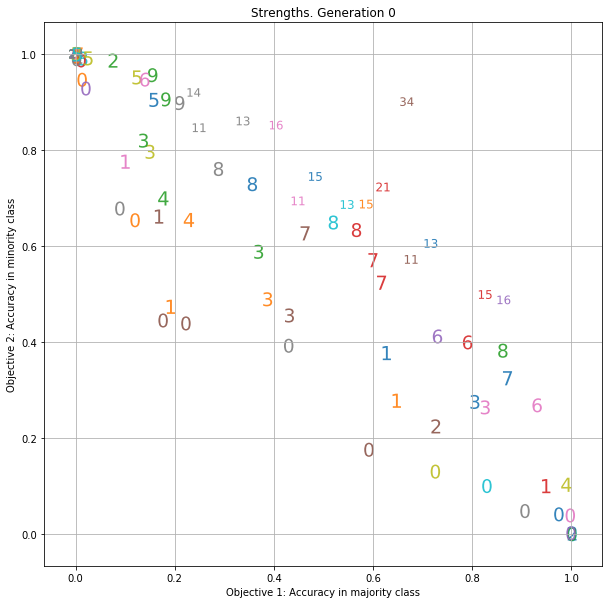

<Figure size 432x288 with 0 Axes>

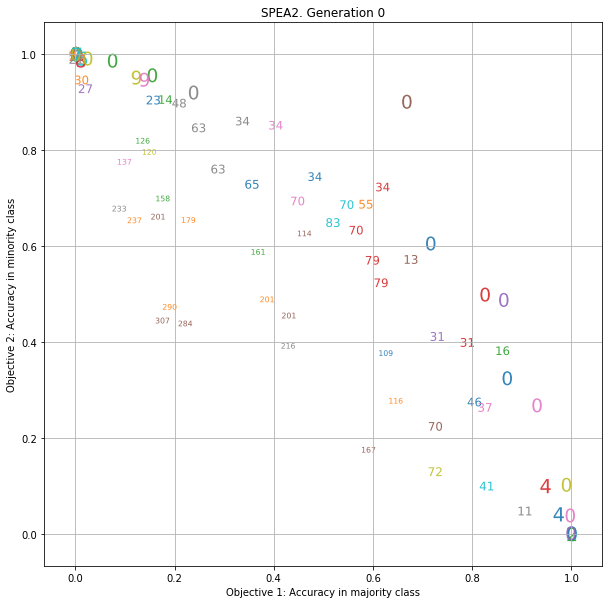

<Figure size 432x288 with 0 Axes>

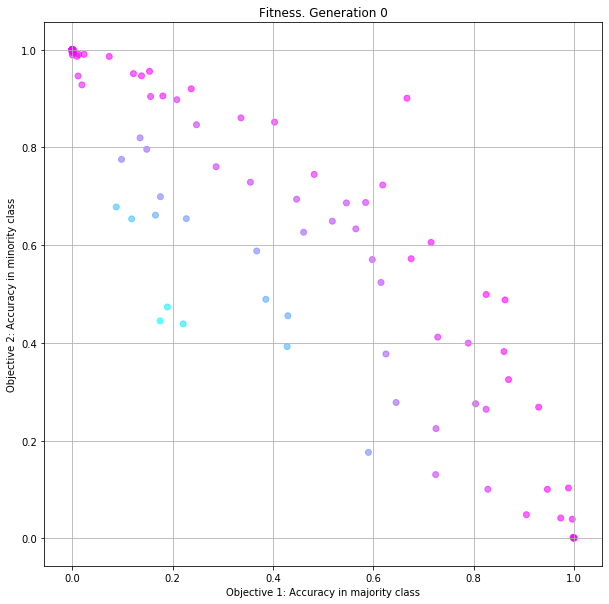

<Figure size 432x288 with 0 Axes>

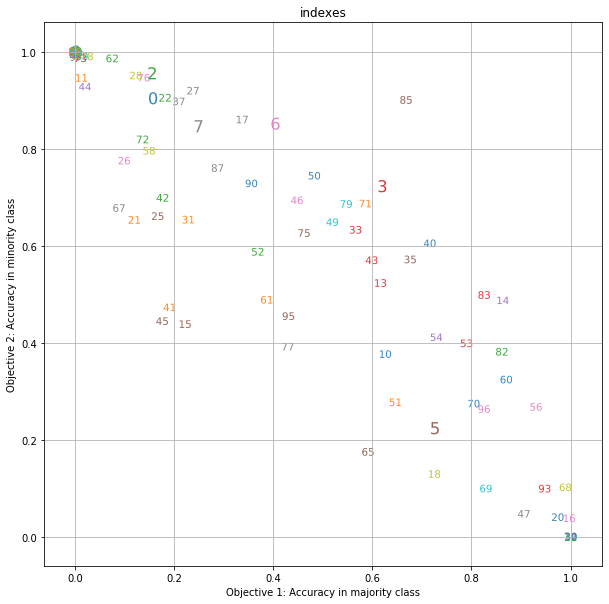

<Figure size 432x288 with 0 Axes>

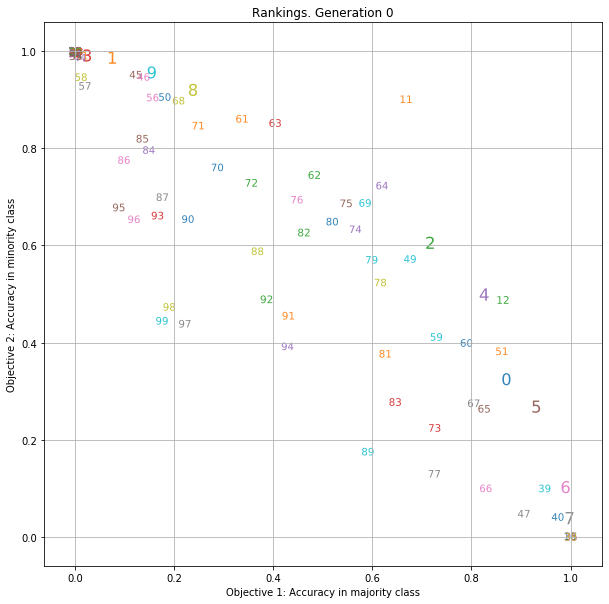

generation: 1


<Figure size 432x288 with 0 Axes>

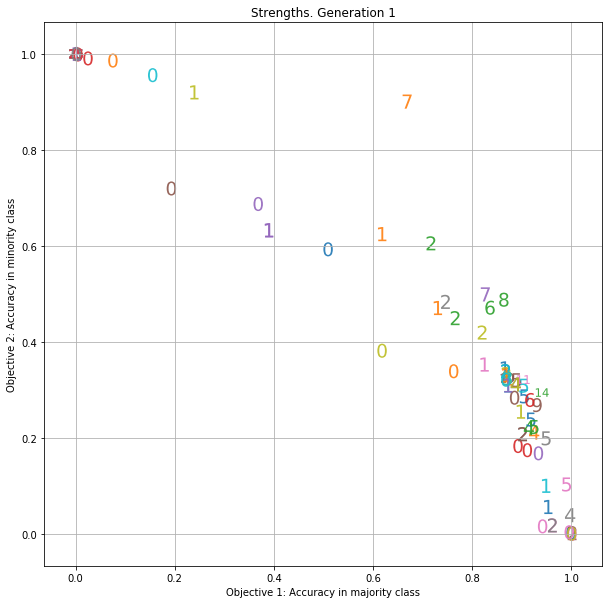

<Figure size 432x288 with 0 Axes>

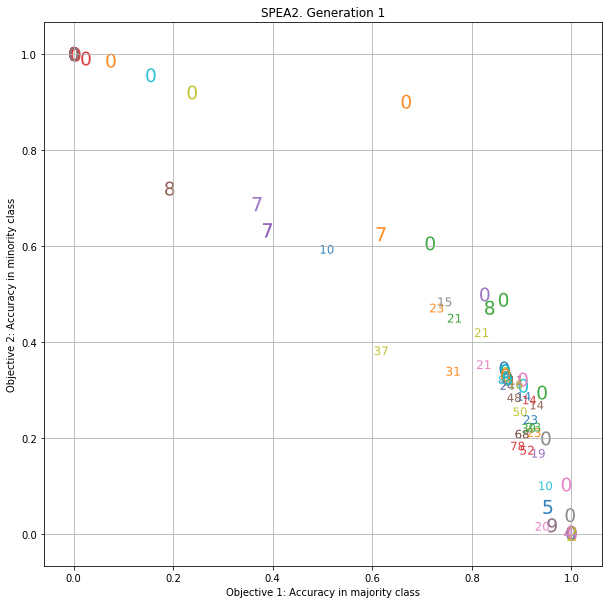

<Figure size 432x288 with 0 Axes>

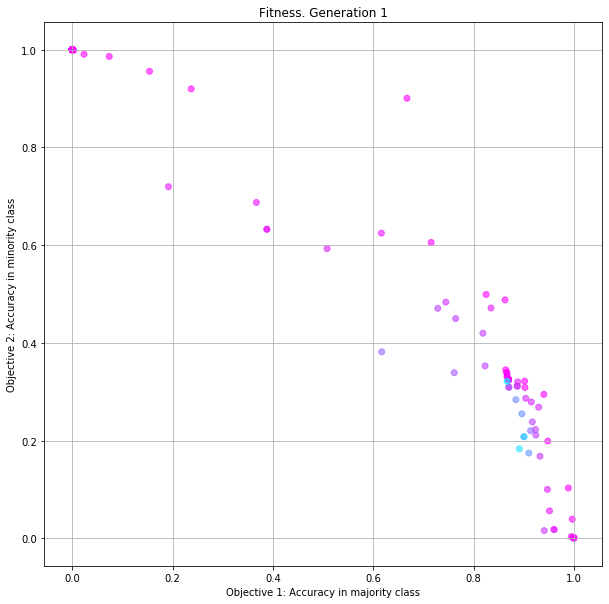

<Figure size 432x288 with 0 Axes>

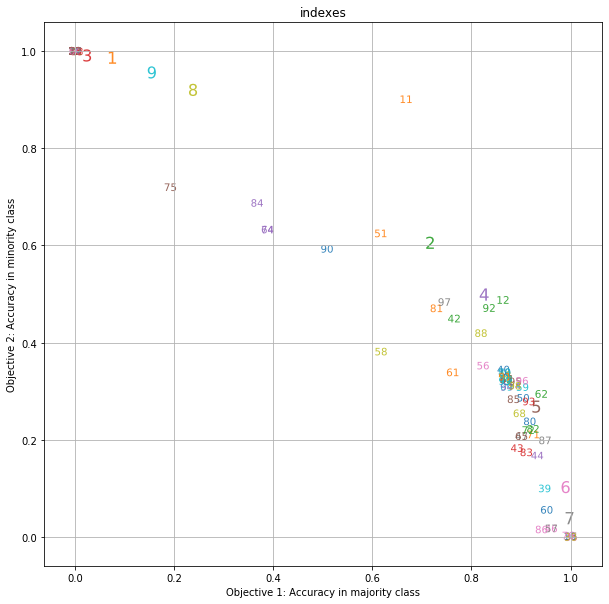

<Figure size 432x288 with 0 Axes>

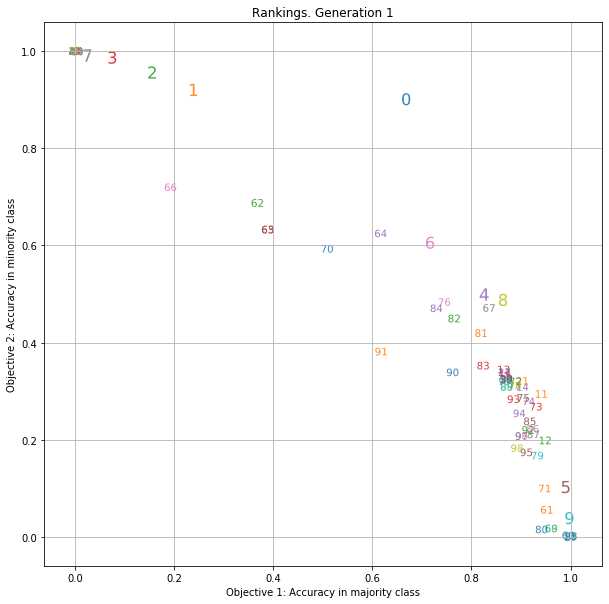

generation: 2


<Figure size 432x288 with 0 Axes>

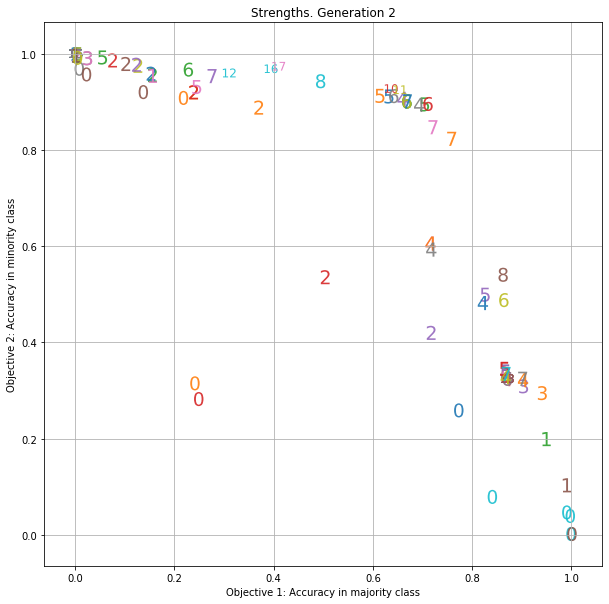

<Figure size 432x288 with 0 Axes>

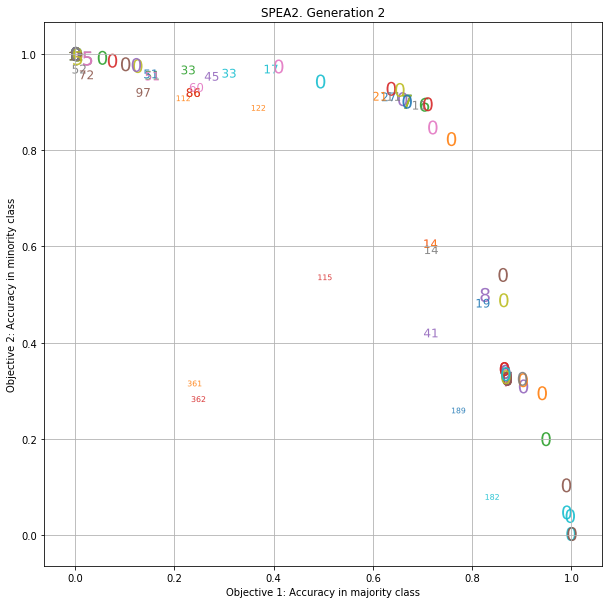

<Figure size 432x288 with 0 Axes>

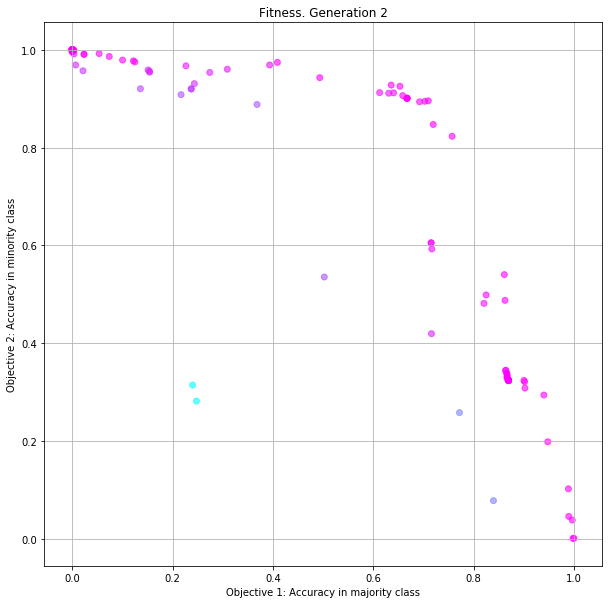

<Figure size 432x288 with 0 Axes>

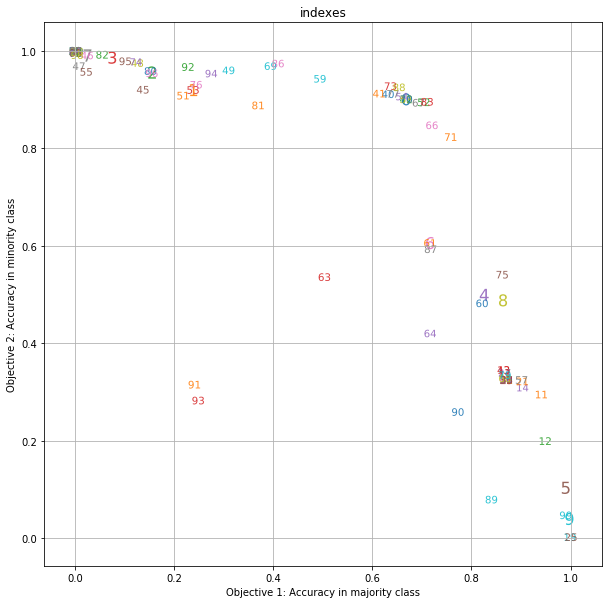

<Figure size 432x288 with 0 Axes>

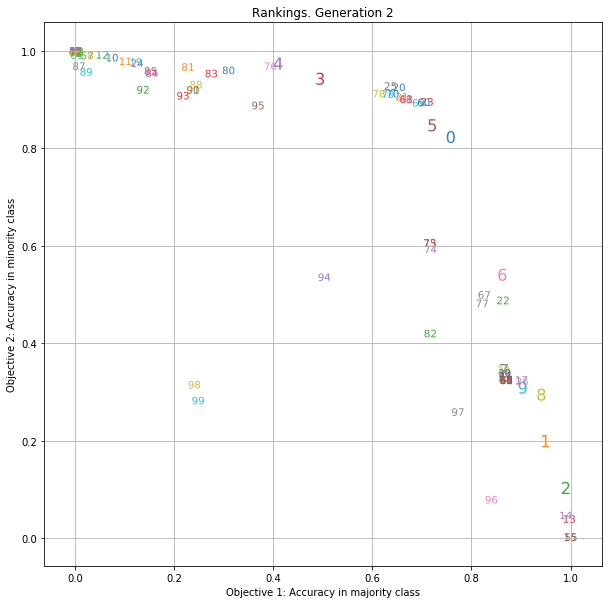

generation: 3


<Figure size 432x288 with 0 Axes>

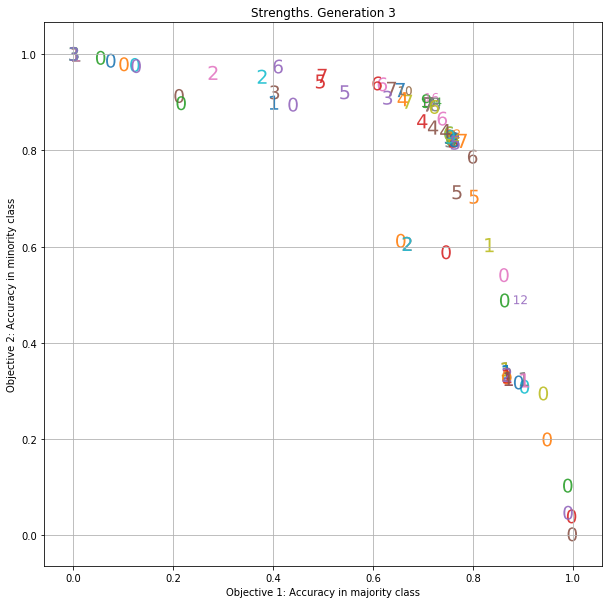

<Figure size 432x288 with 0 Axes>

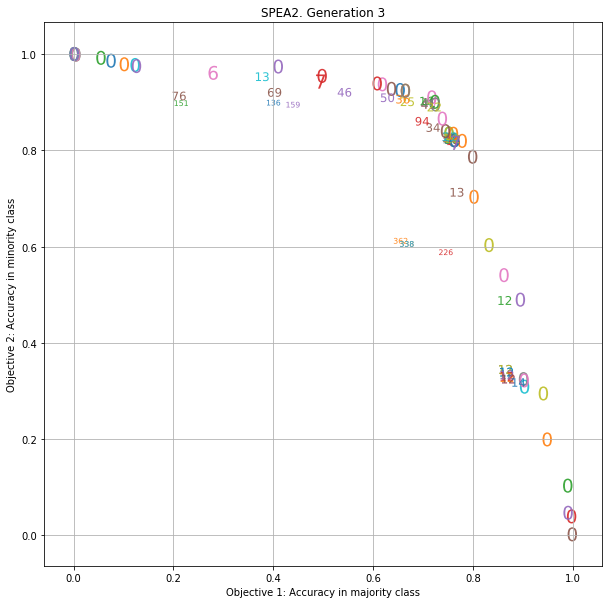

<Figure size 432x288 with 0 Axes>

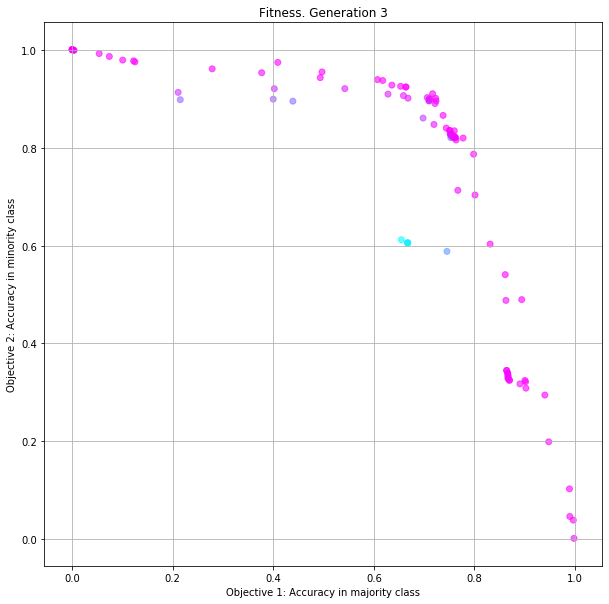

<Figure size 432x288 with 0 Axes>

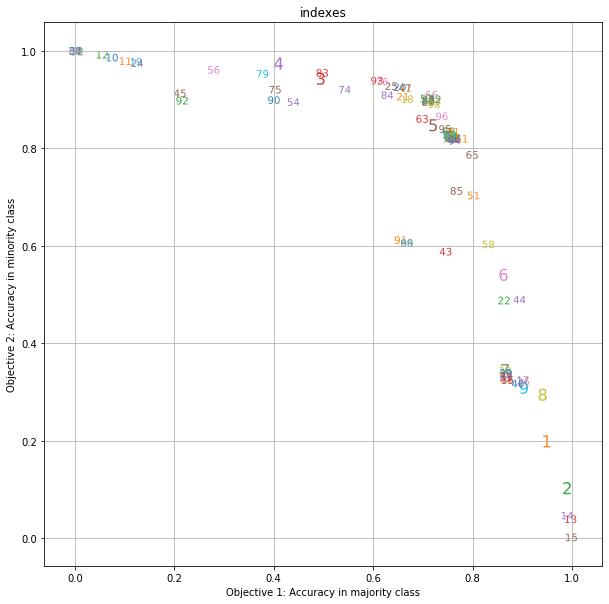

<Figure size 432x288 with 0 Axes>

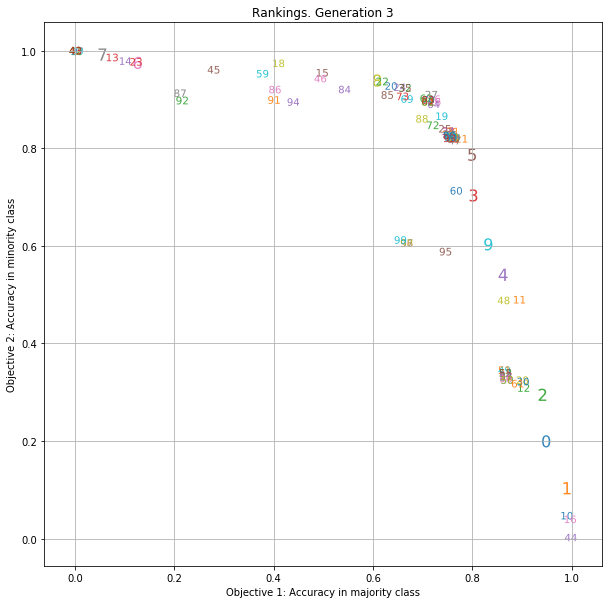

generation: 4


<Figure size 432x288 with 0 Axes>

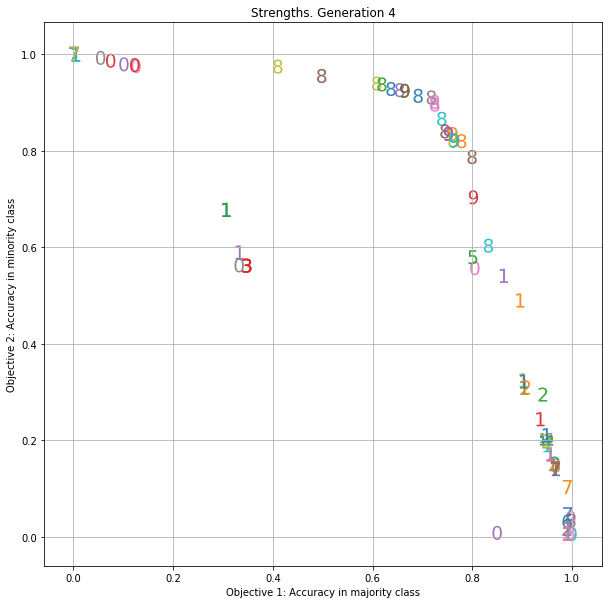

<Figure size 432x288 with 0 Axes>

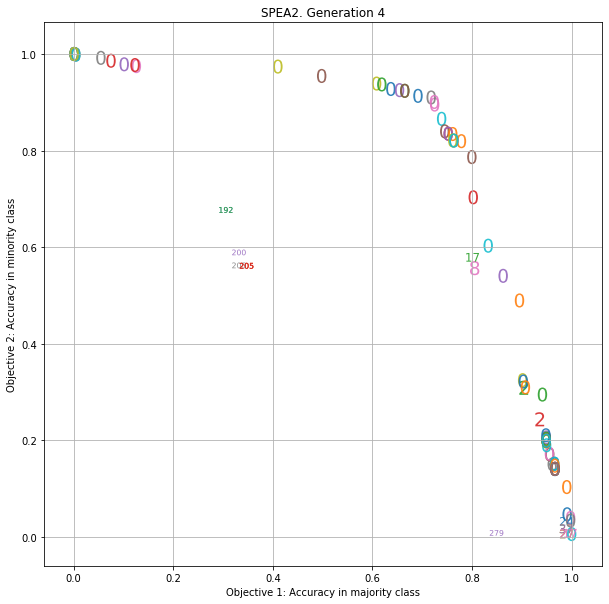

<Figure size 432x288 with 0 Axes>

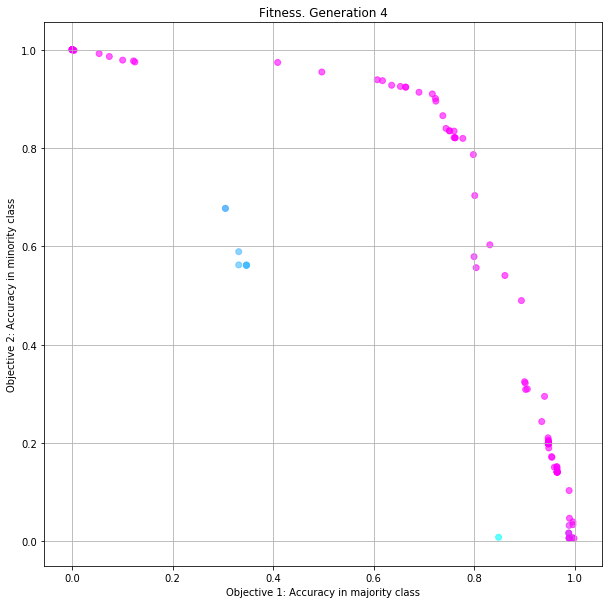

<Figure size 432x288 with 0 Axes>

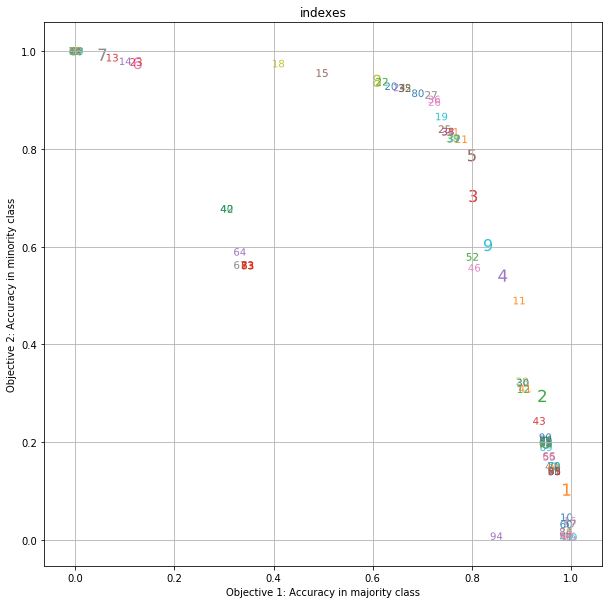

<Figure size 432x288 with 0 Axes>

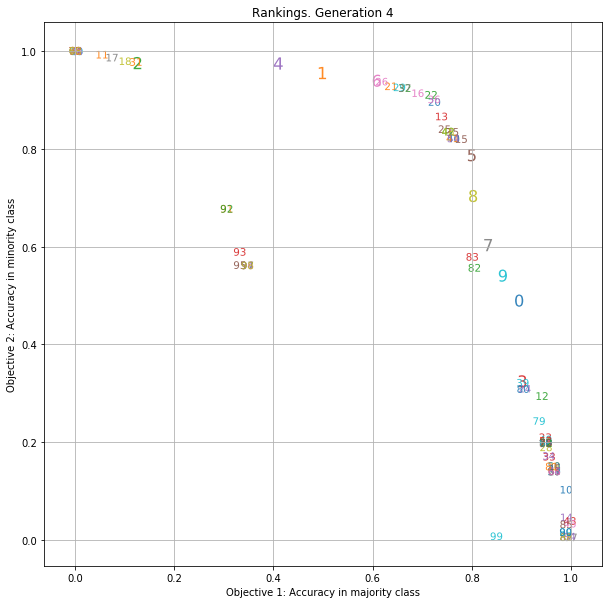

generation: 5


<Figure size 432x288 with 0 Axes>

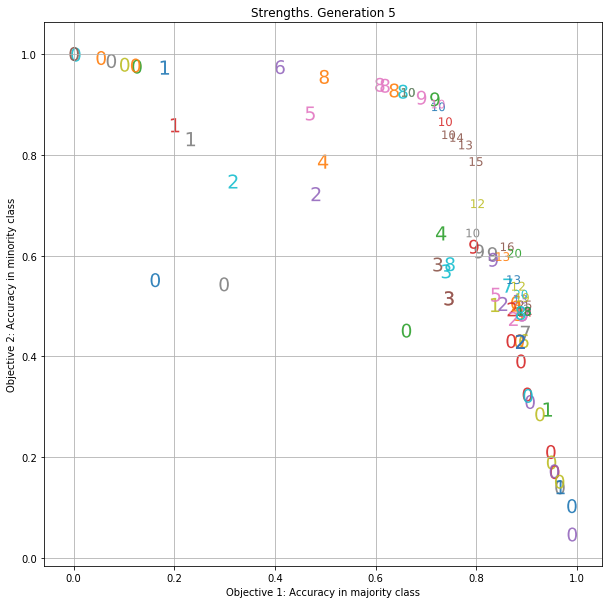

<Figure size 432x288 with 0 Axes>

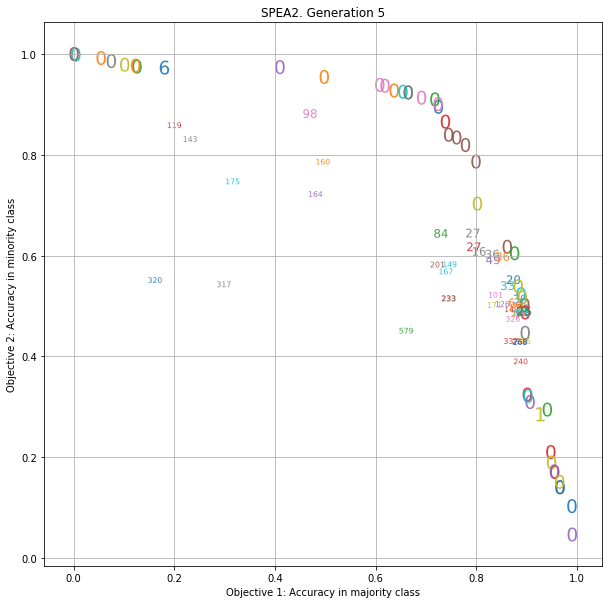

<Figure size 432x288 with 0 Axes>

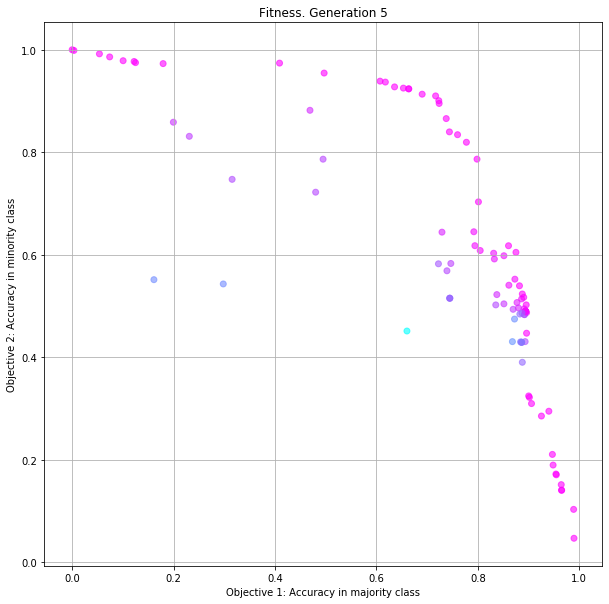

<Figure size 432x288 with 0 Axes>

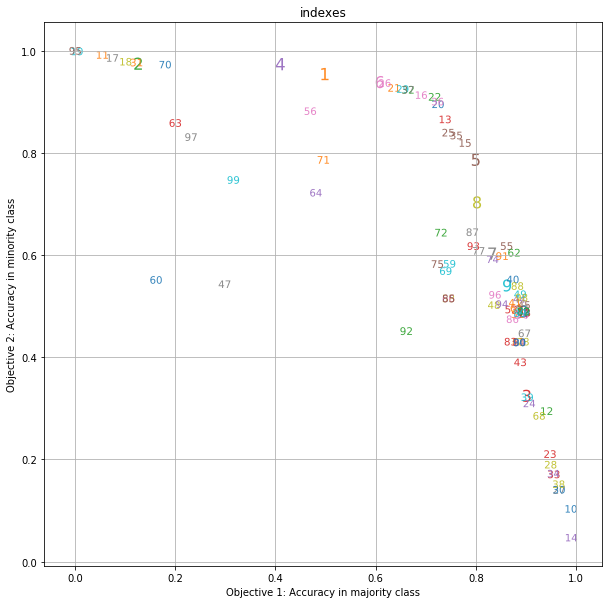

<Figure size 432x288 with 0 Axes>

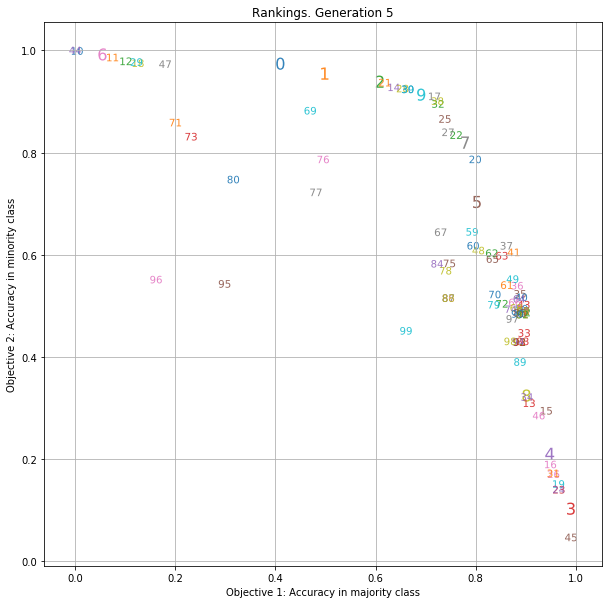

generation: 6


<Figure size 432x288 with 0 Axes>

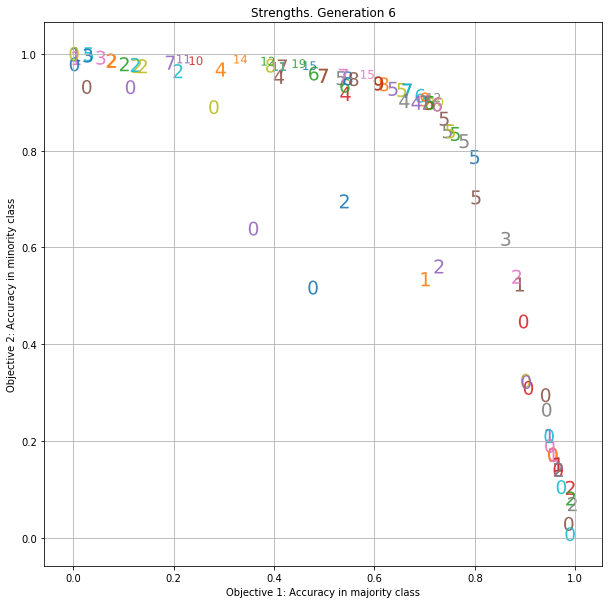

<Figure size 432x288 with 0 Axes>

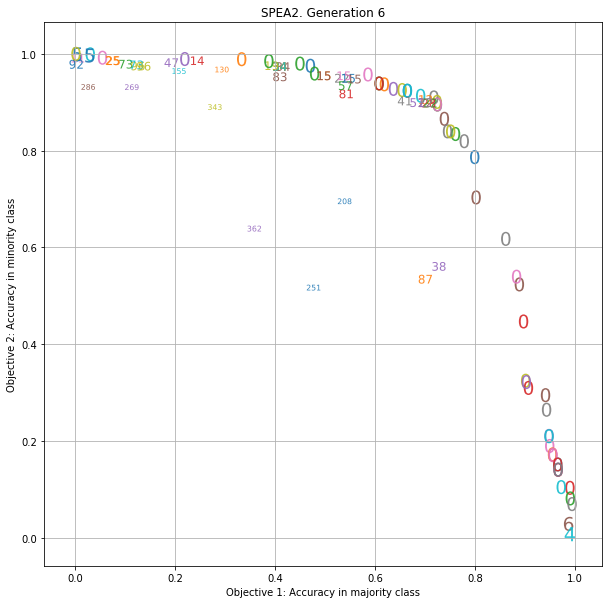

<Figure size 432x288 with 0 Axes>

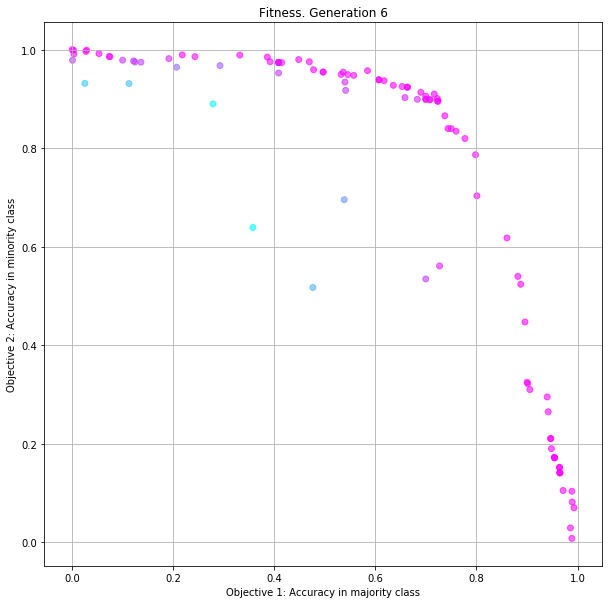

<Figure size 432x288 with 0 Axes>

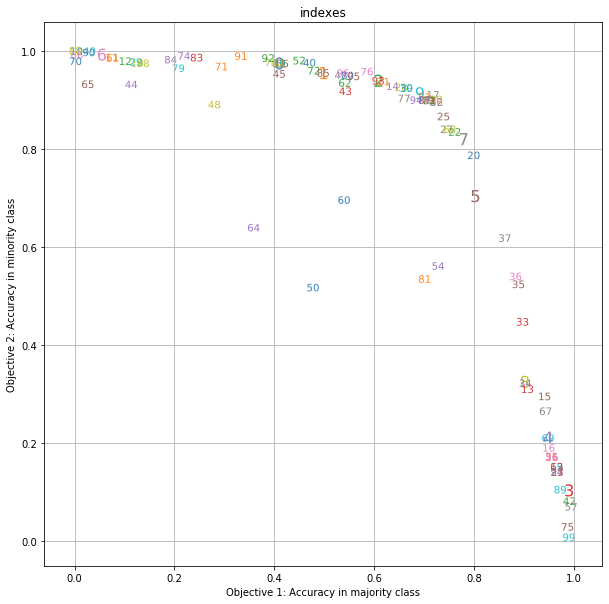

<Figure size 432x288 with 0 Axes>

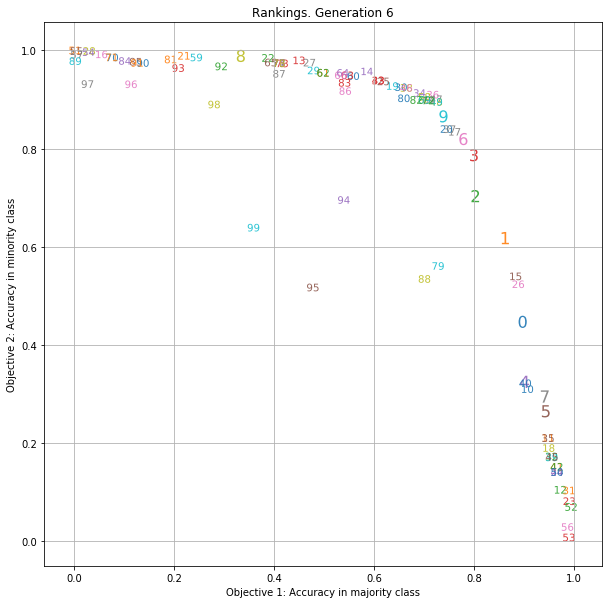

generation: 7


<Figure size 432x288 with 0 Axes>

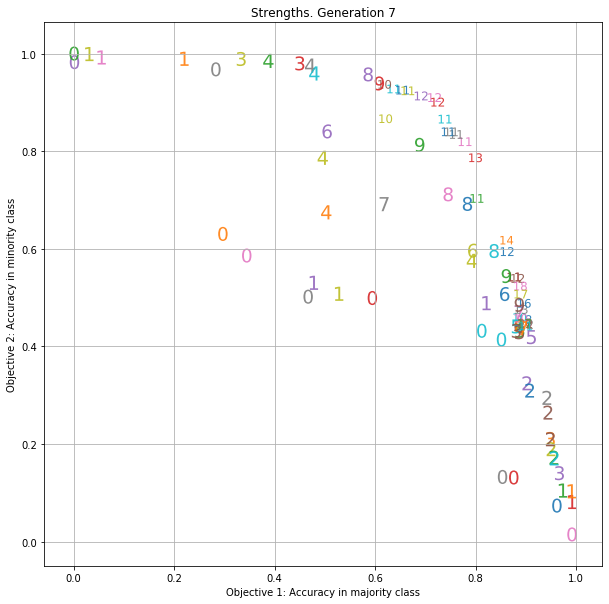

<Figure size 432x288 with 0 Axes>

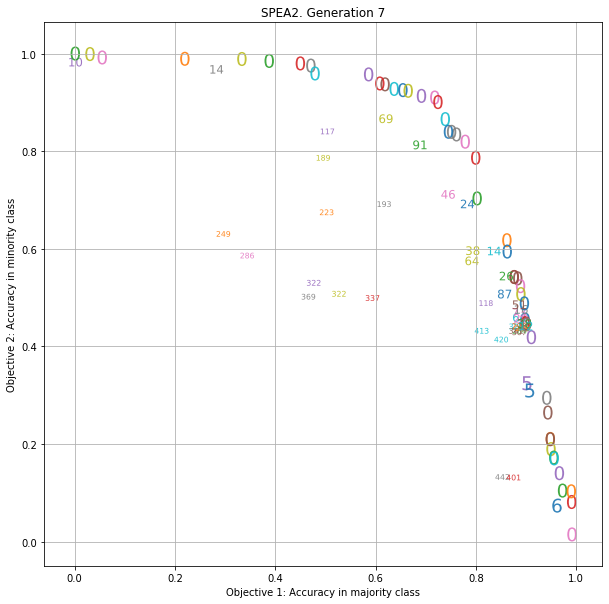

<Figure size 432x288 with 0 Axes>

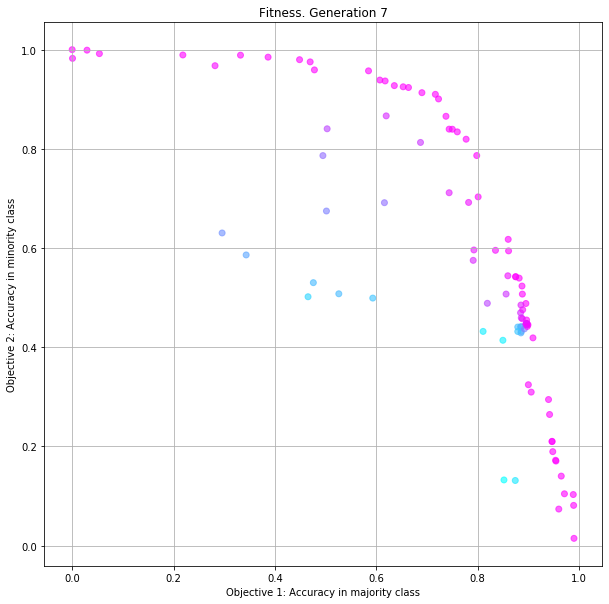

<Figure size 432x288 with 0 Axes>

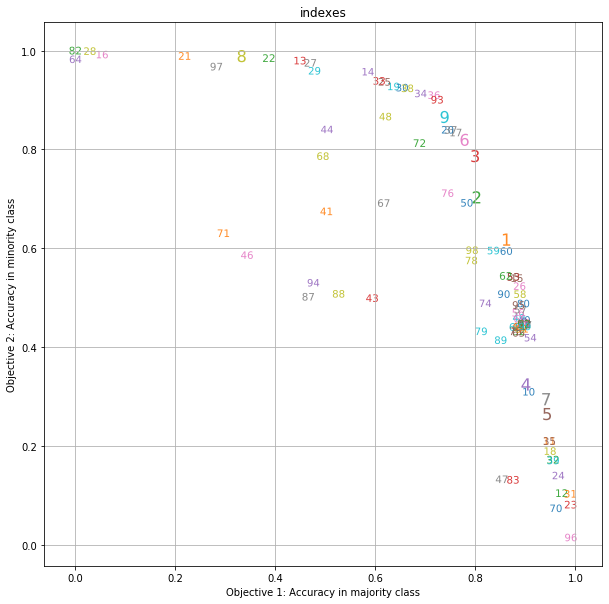

<Figure size 432x288 with 0 Axes>

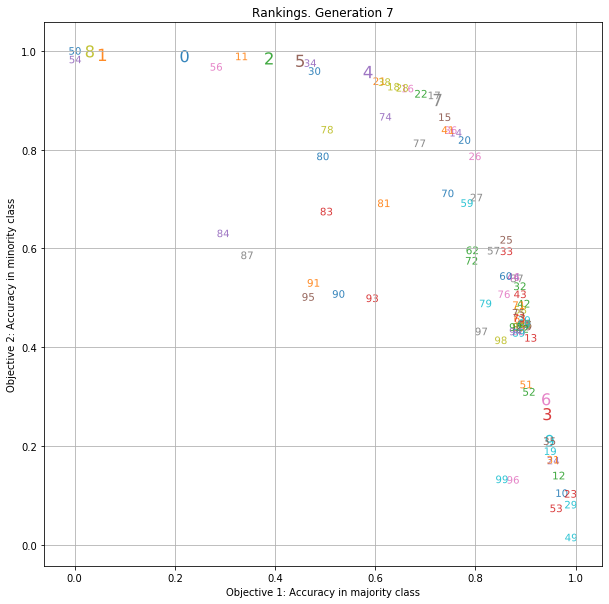

generation: 8


<Figure size 432x288 with 0 Axes>

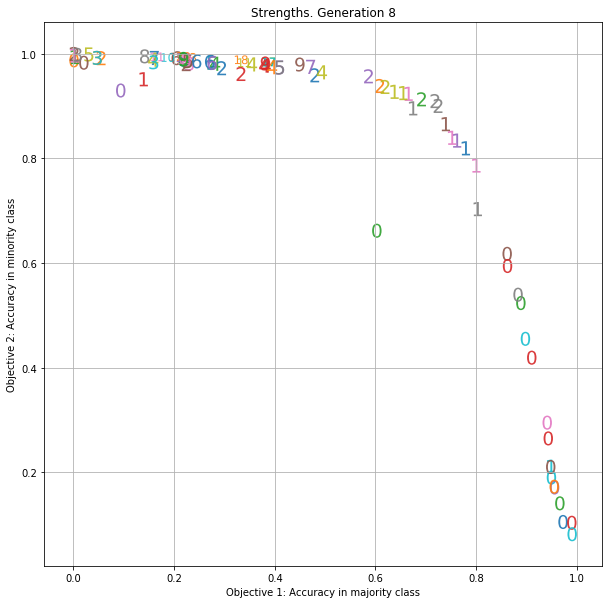

<Figure size 432x288 with 0 Axes>

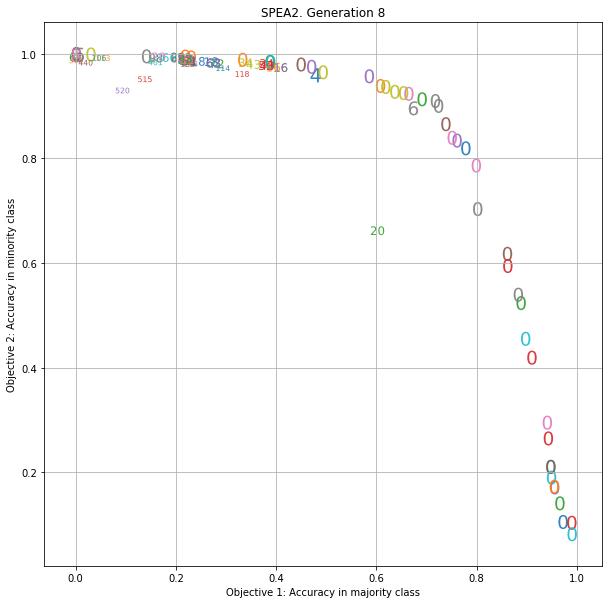

<Figure size 432x288 with 0 Axes>

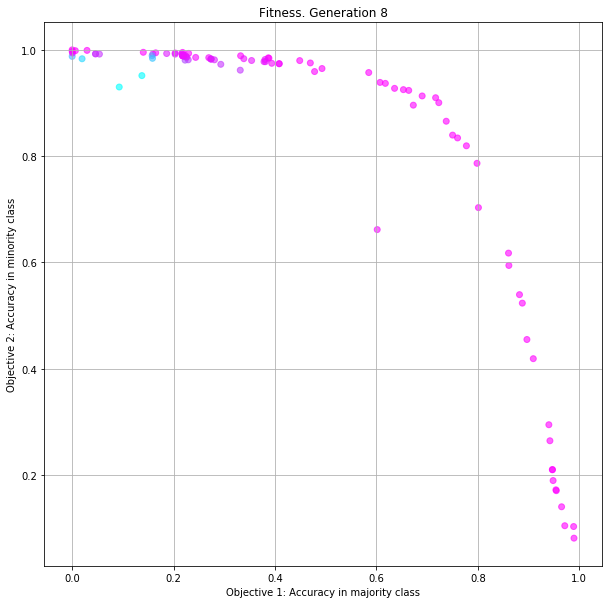

<Figure size 432x288 with 0 Axes>

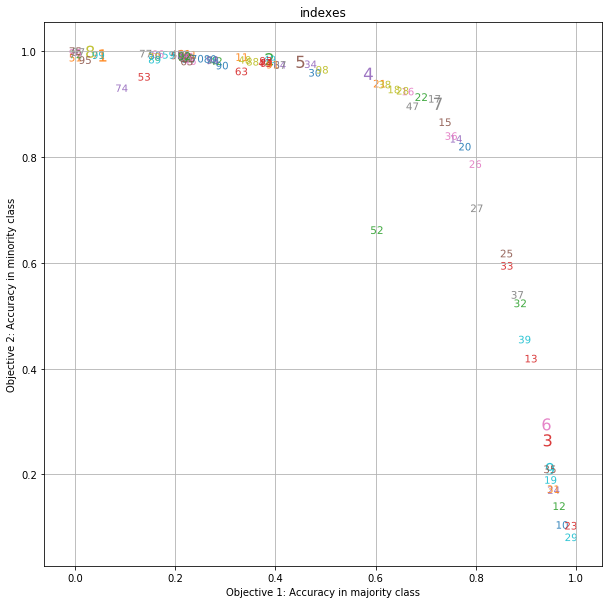

<Figure size 432x288 with 0 Axes>

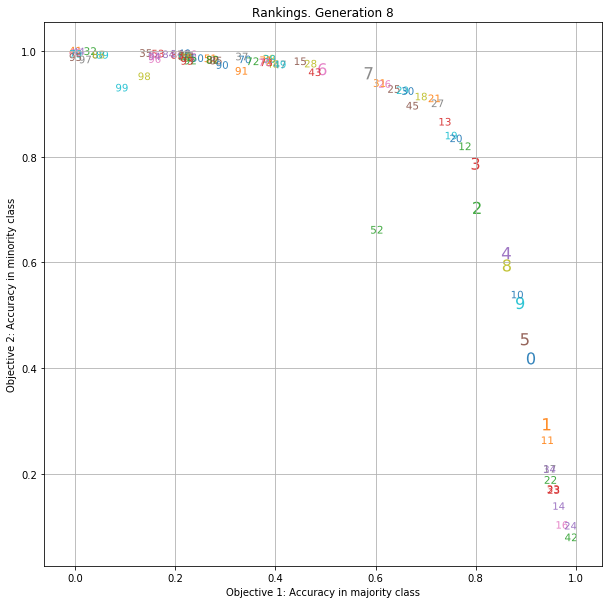

generation: 9


<Figure size 432x288 with 0 Axes>

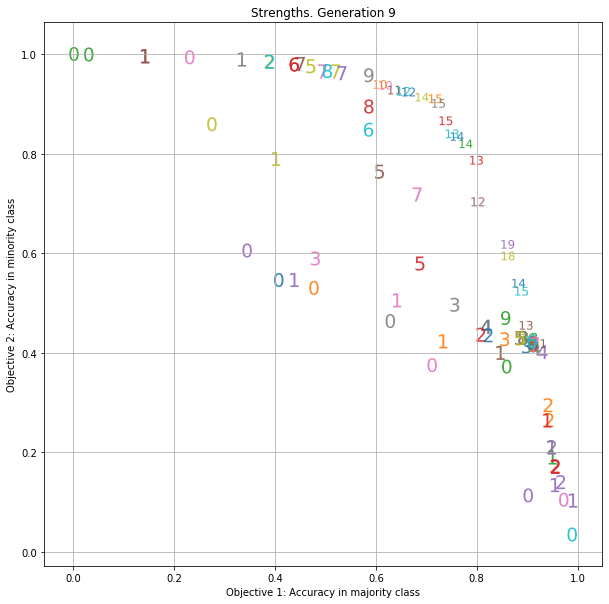

<Figure size 432x288 with 0 Axes>

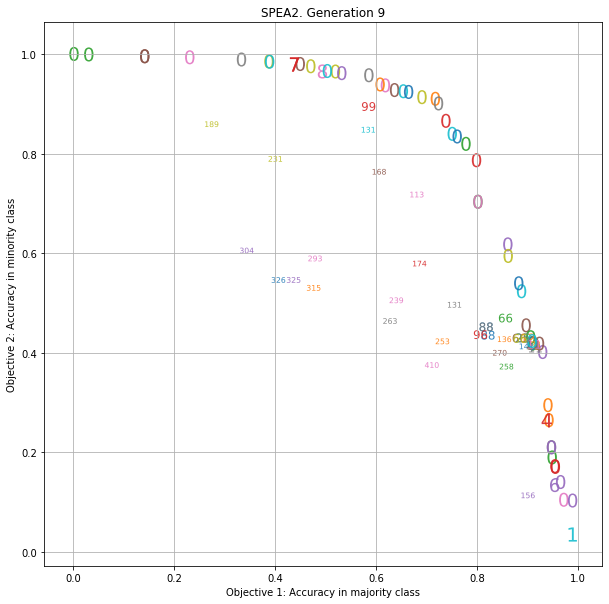

<Figure size 432x288 with 0 Axes>

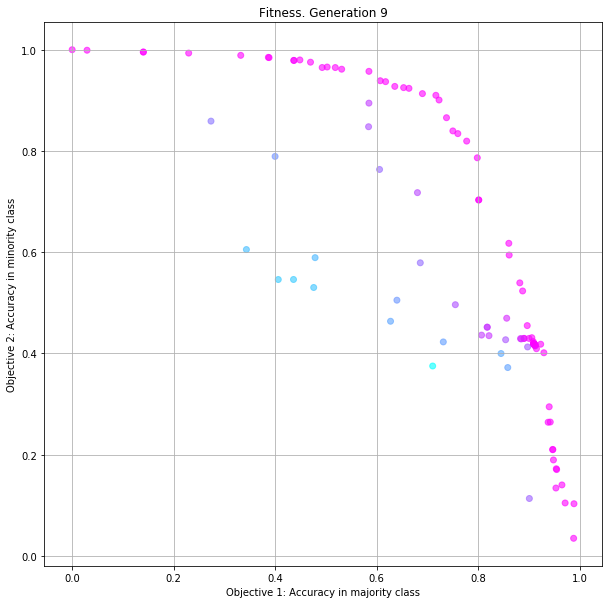

<Figure size 432x288 with 0 Axes>

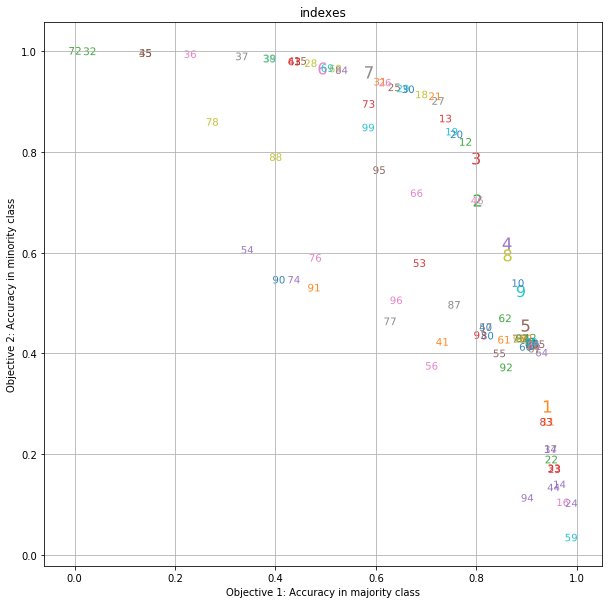

<Figure size 432x288 with 0 Axes>

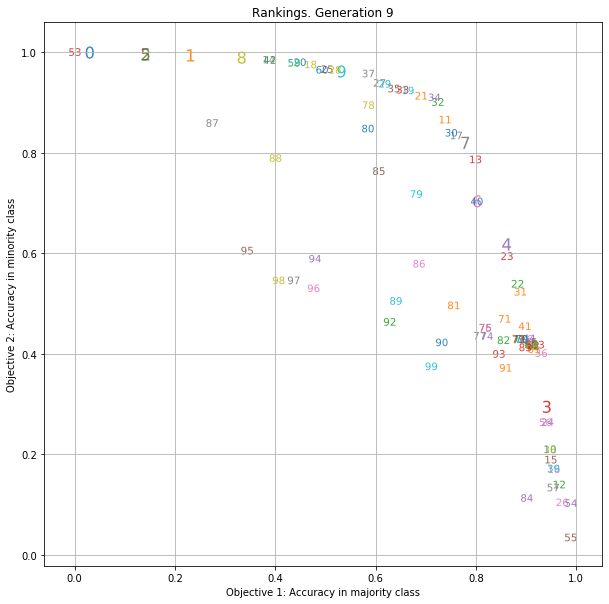

generation: 10


<Figure size 432x288 with 0 Axes>

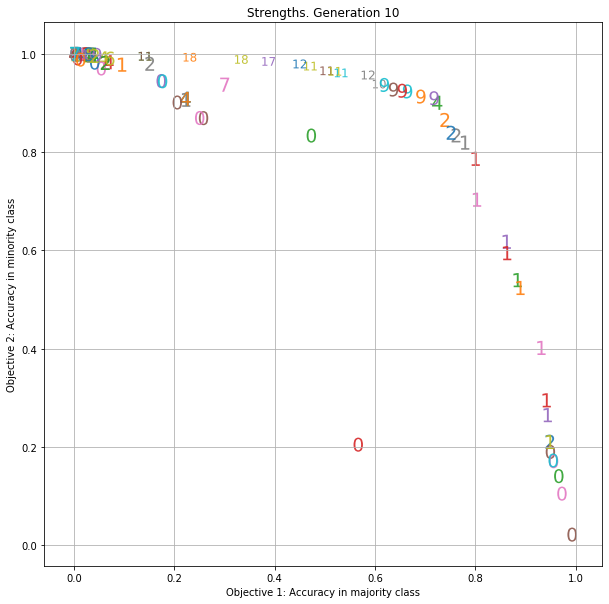

<Figure size 432x288 with 0 Axes>

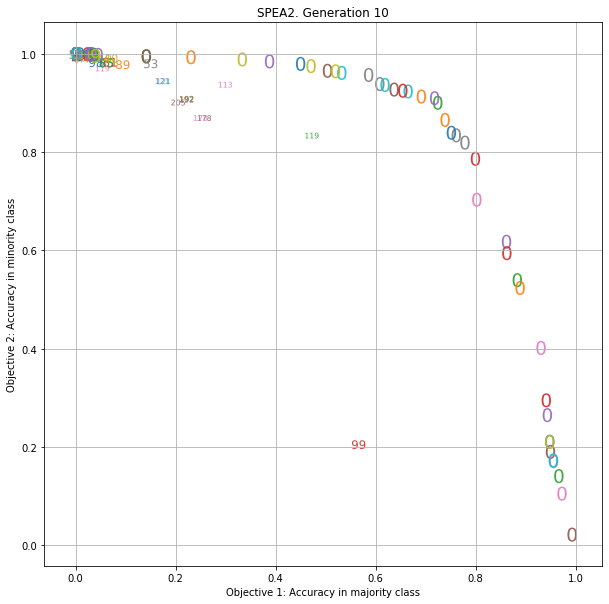

<Figure size 432x288 with 0 Axes>

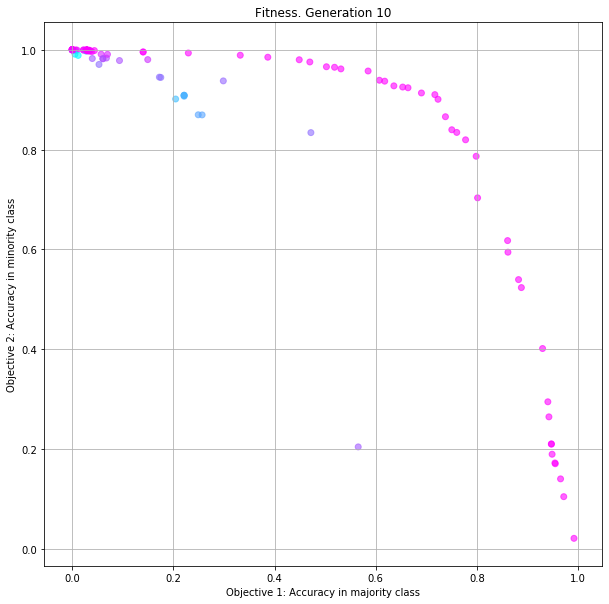

<Figure size 432x288 with 0 Axes>

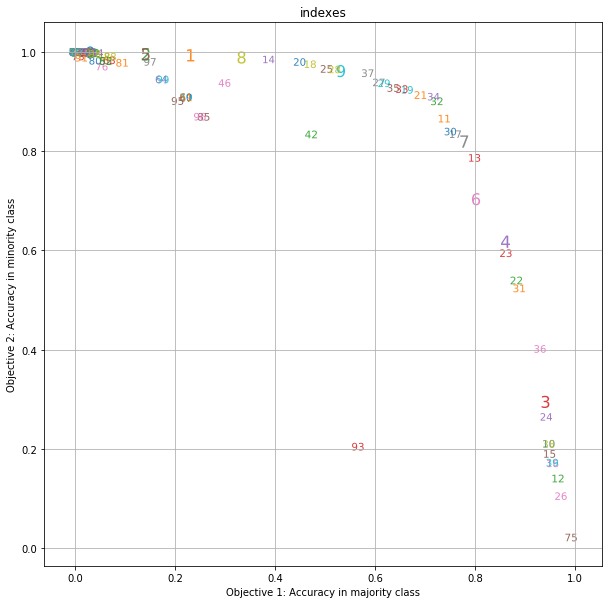

<Figure size 432x288 with 0 Axes>

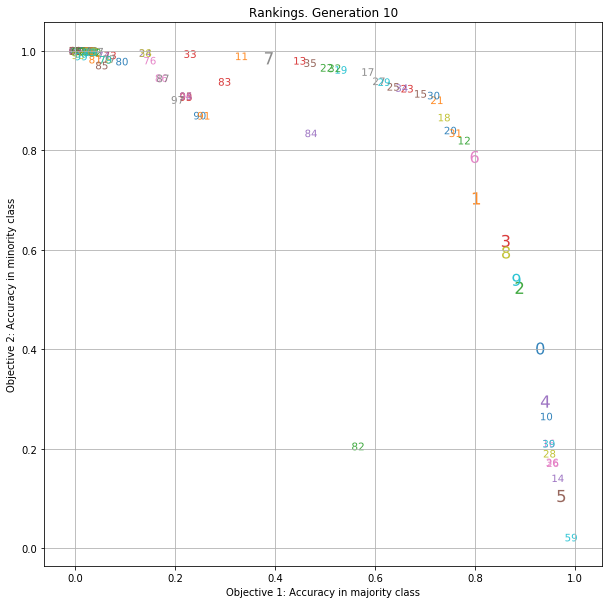

generation: 11


<Figure size 432x288 with 0 Axes>

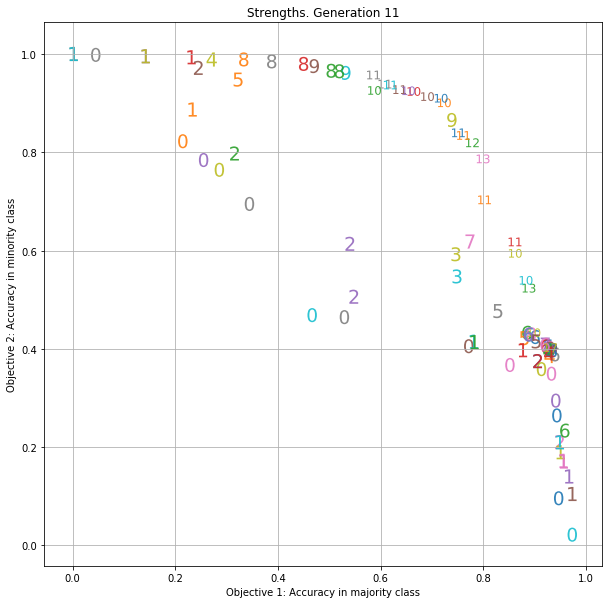

<Figure size 432x288 with 0 Axes>

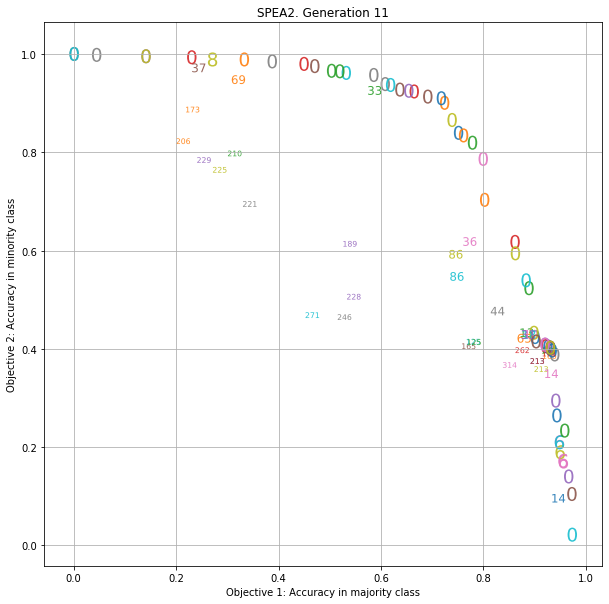

<Figure size 432x288 with 0 Axes>

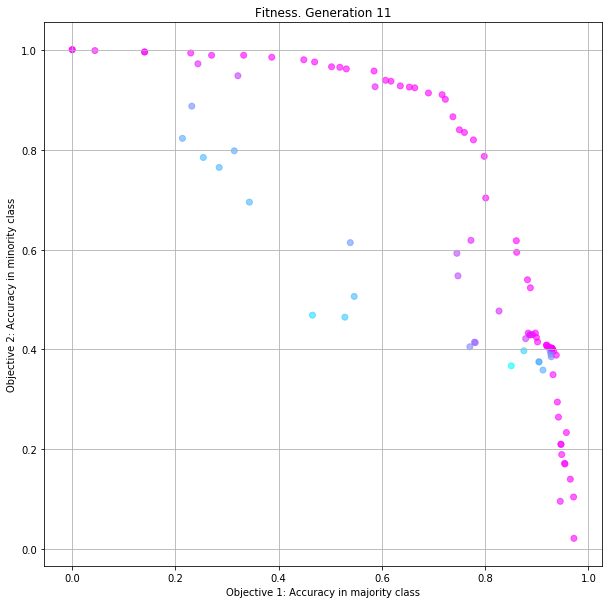

<Figure size 432x288 with 0 Axes>

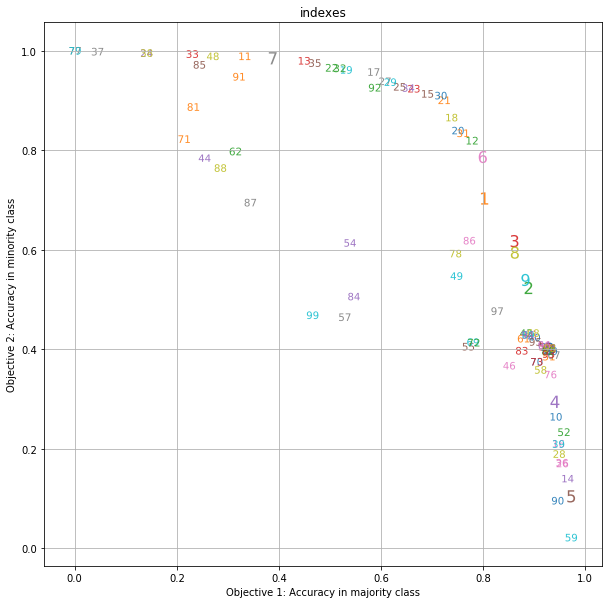

<Figure size 432x288 with 0 Axes>

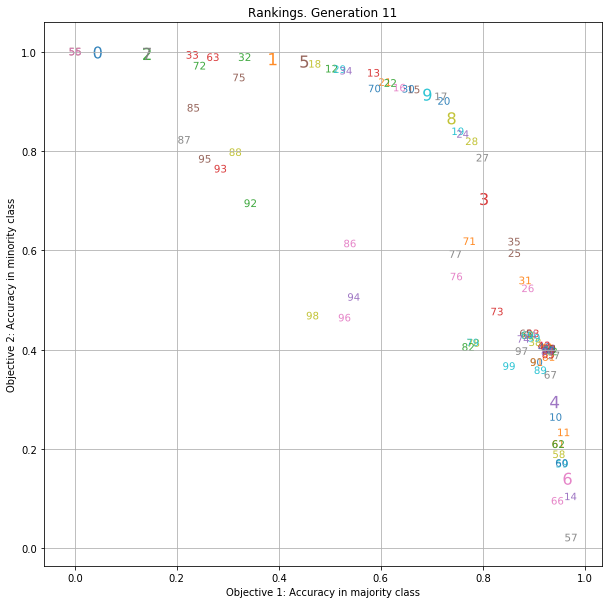

generation: 12


<Figure size 432x288 with 0 Axes>

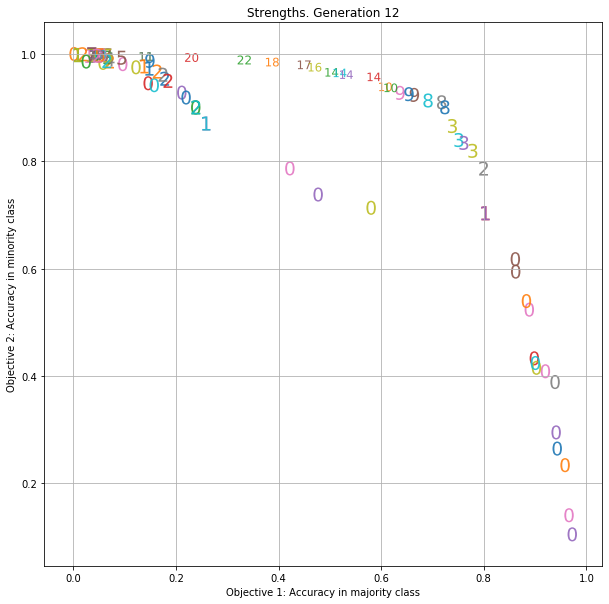

<Figure size 432x288 with 0 Axes>

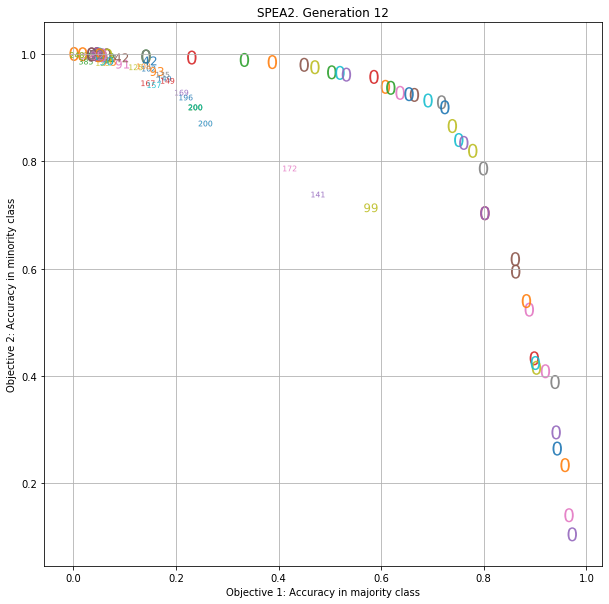

<Figure size 432x288 with 0 Axes>

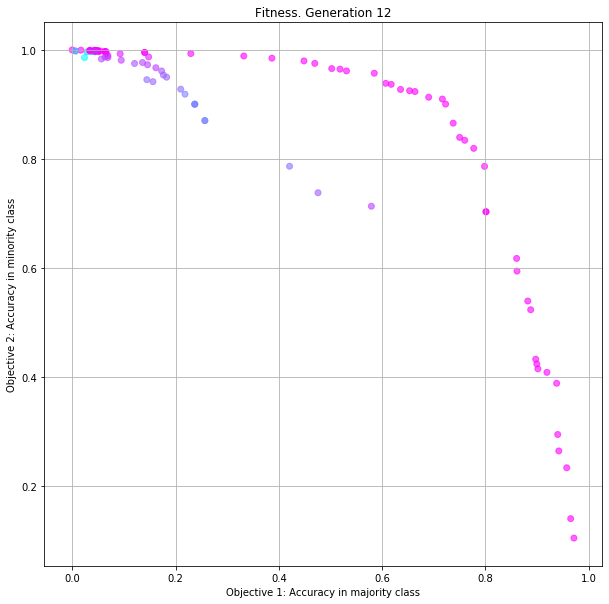

<Figure size 432x288 with 0 Axes>

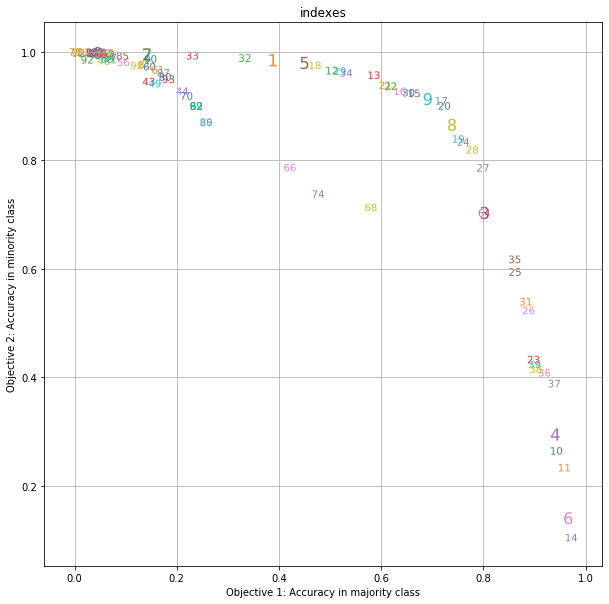

<Figure size 432x288 with 0 Axes>

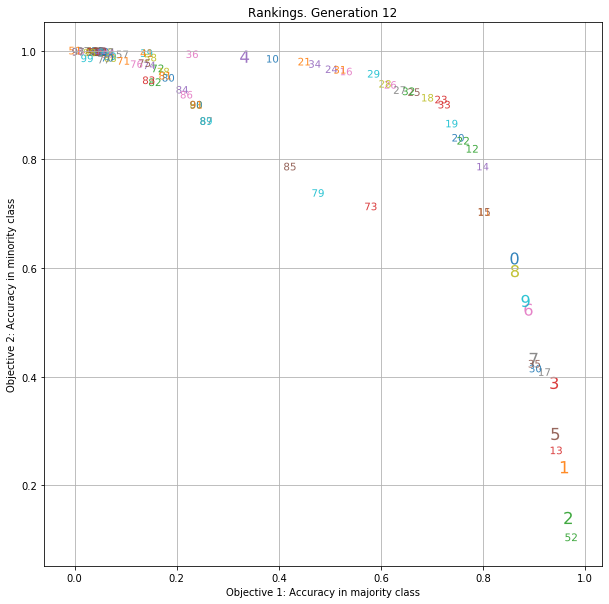

generation: 13


<Figure size 432x288 with 0 Axes>

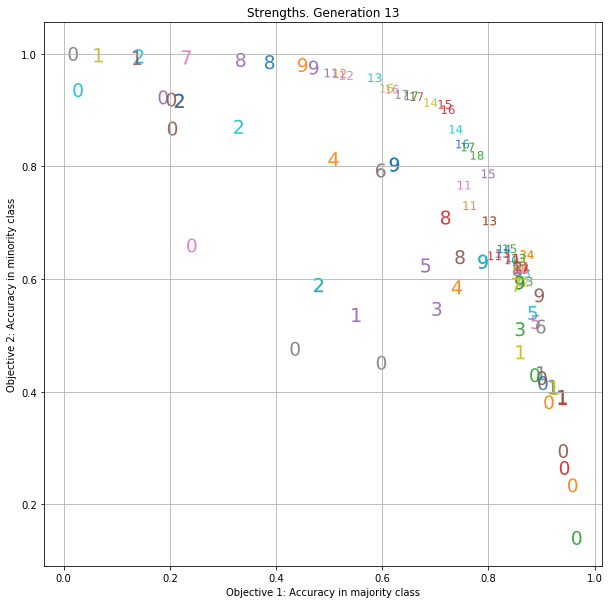

<Figure size 432x288 with 0 Axes>

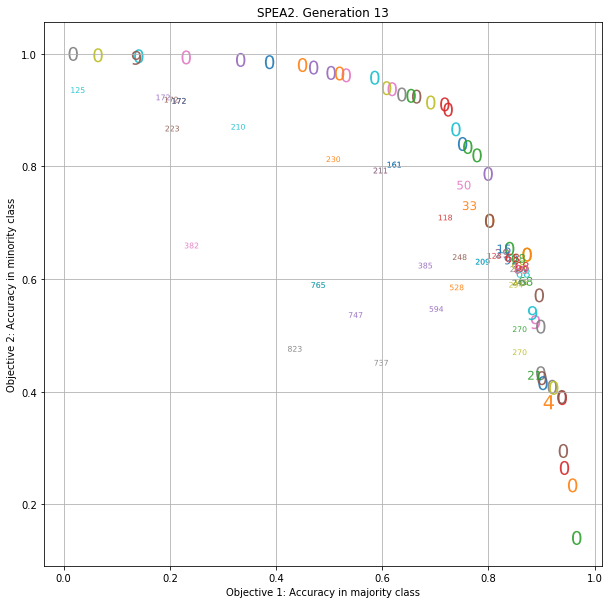

<Figure size 432x288 with 0 Axes>

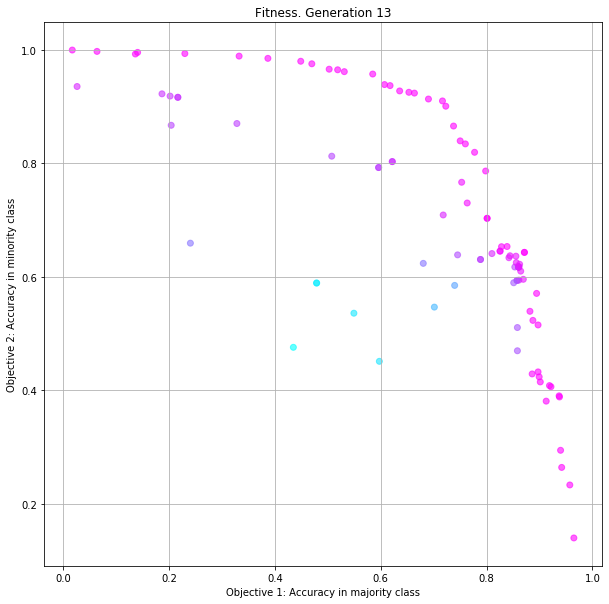

<Figure size 432x288 with 0 Axes>

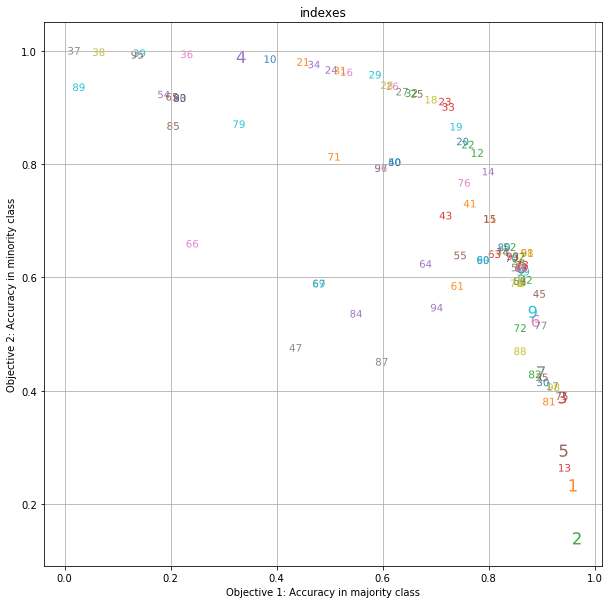

<Figure size 432x288 with 0 Axes>

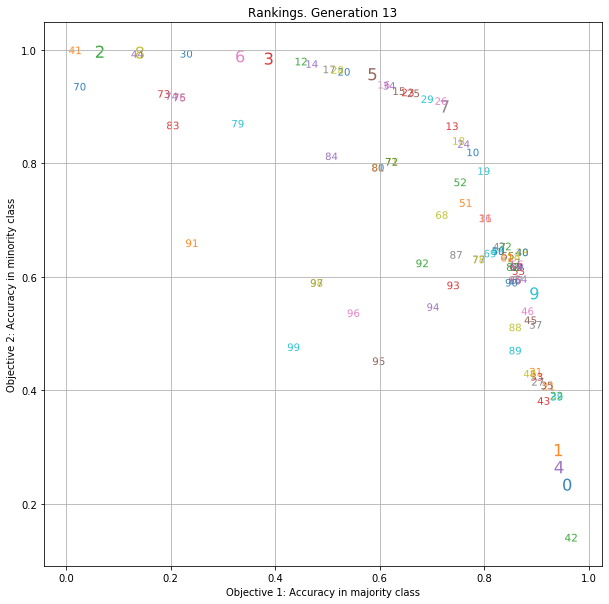

generation: 14


<Figure size 432x288 with 0 Axes>

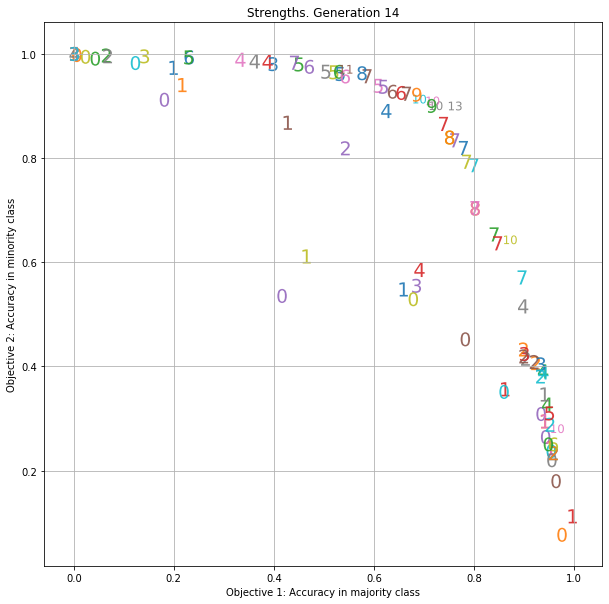

<Figure size 432x288 with 0 Axes>

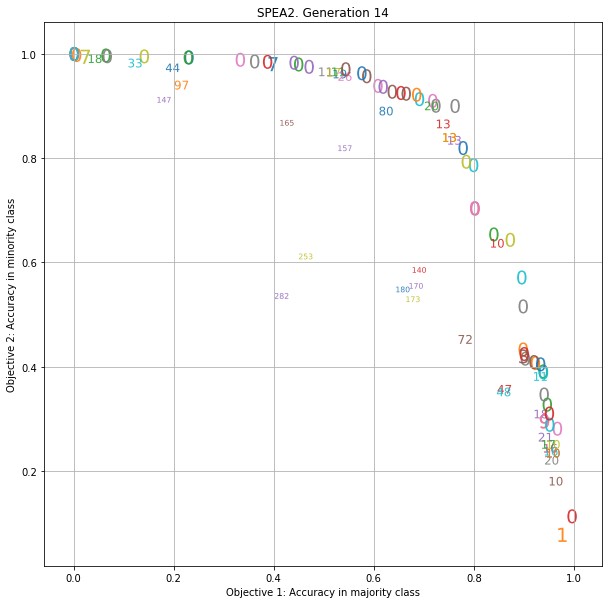

<Figure size 432x288 with 0 Axes>

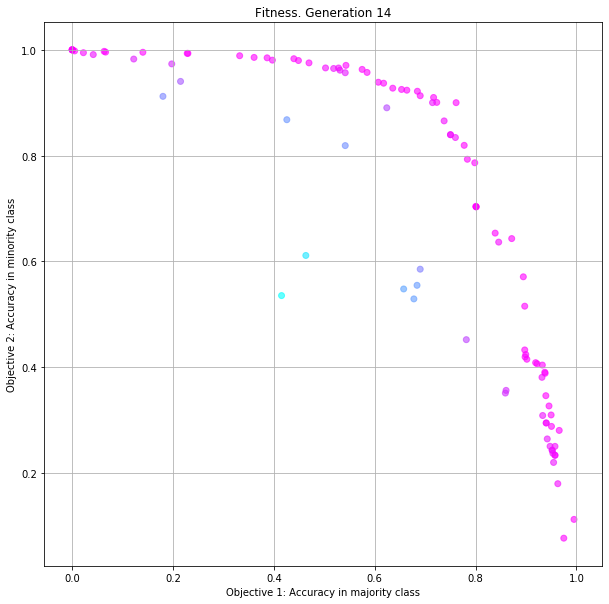

<Figure size 432x288 with 0 Axes>

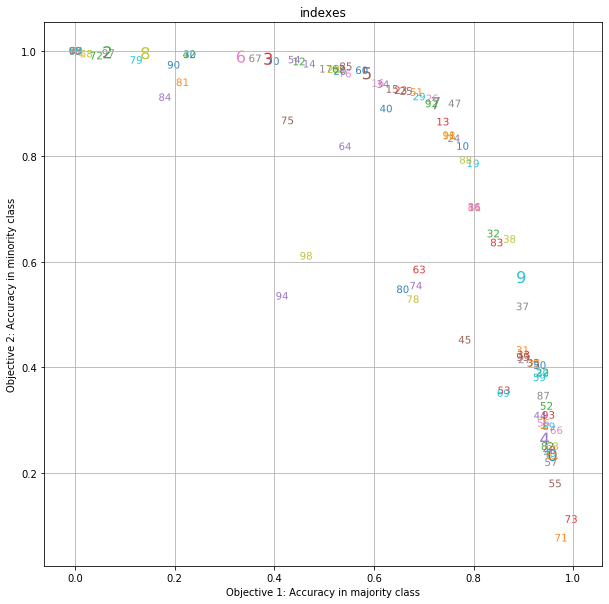

<Figure size 432x288 with 0 Axes>

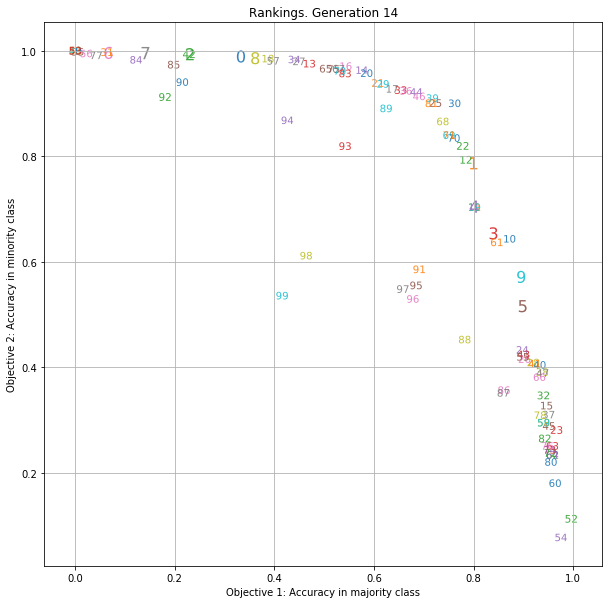

generation: 15


<Figure size 432x288 with 0 Axes>

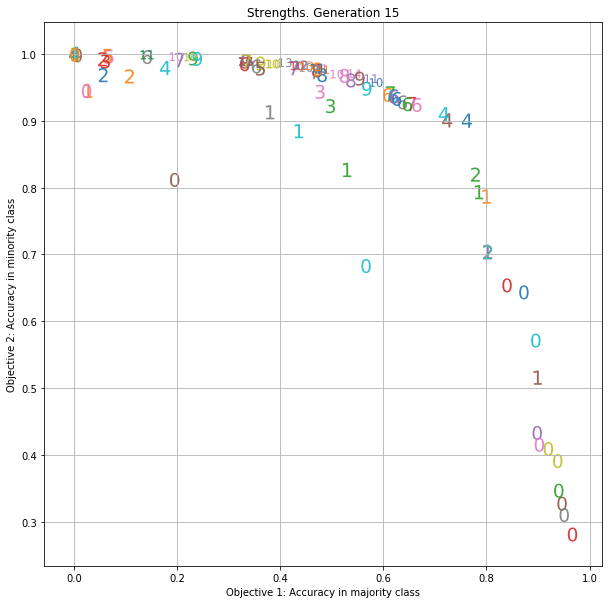

<Figure size 432x288 with 0 Axes>

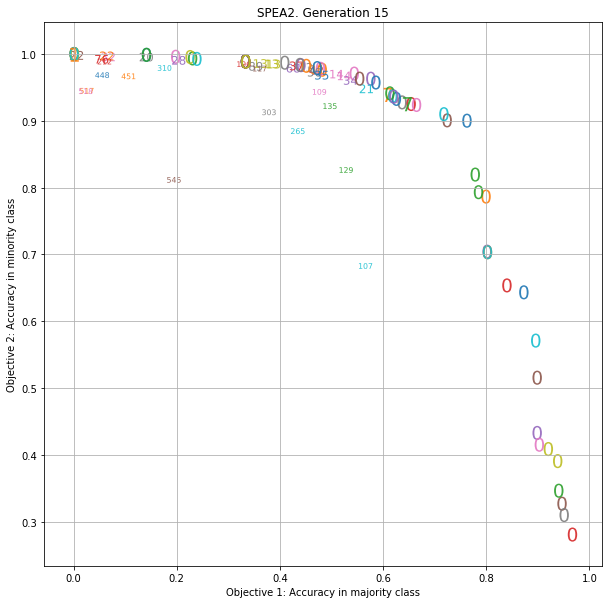

<Figure size 432x288 with 0 Axes>

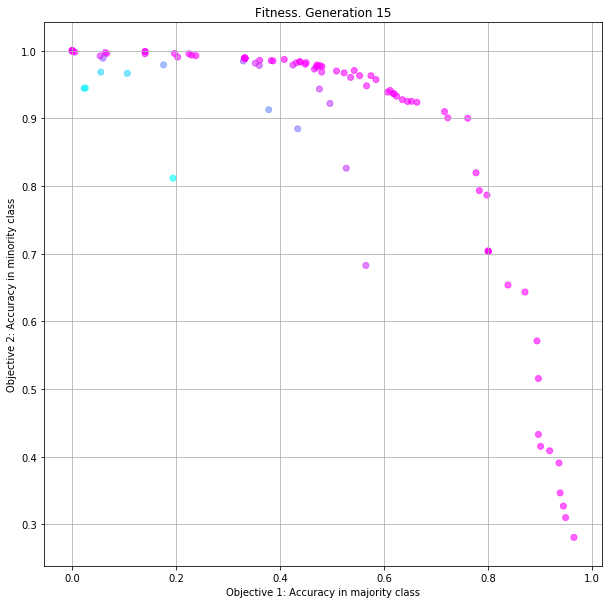

<Figure size 432x288 with 0 Axes>

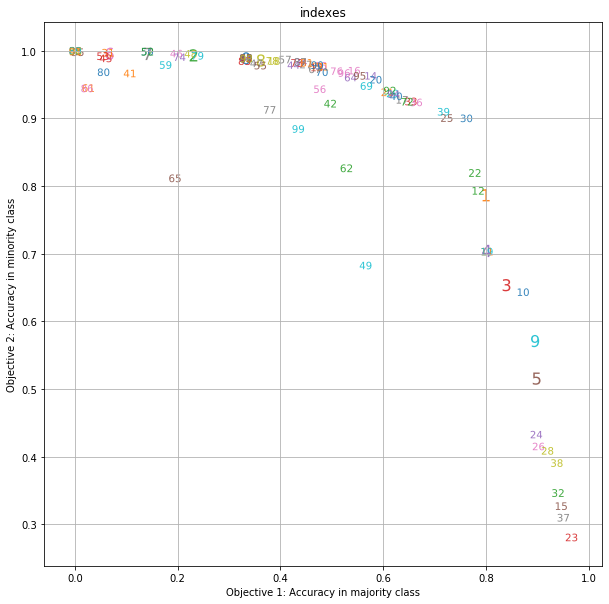

<Figure size 432x288 with 0 Axes>

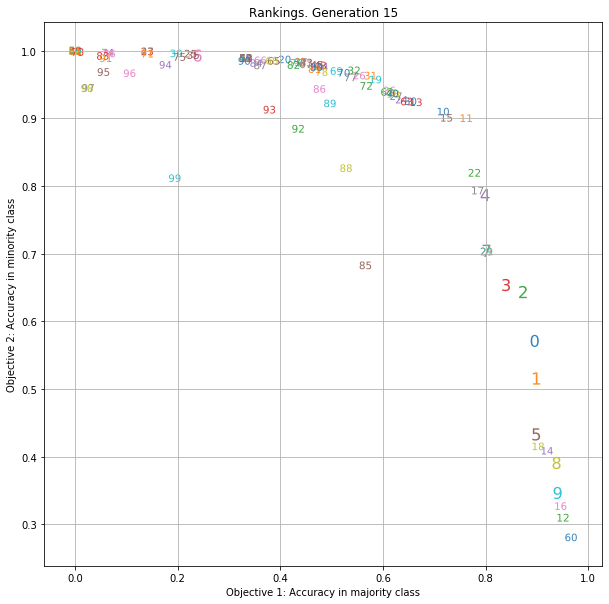

generation: 16


<Figure size 432x288 with 0 Axes>

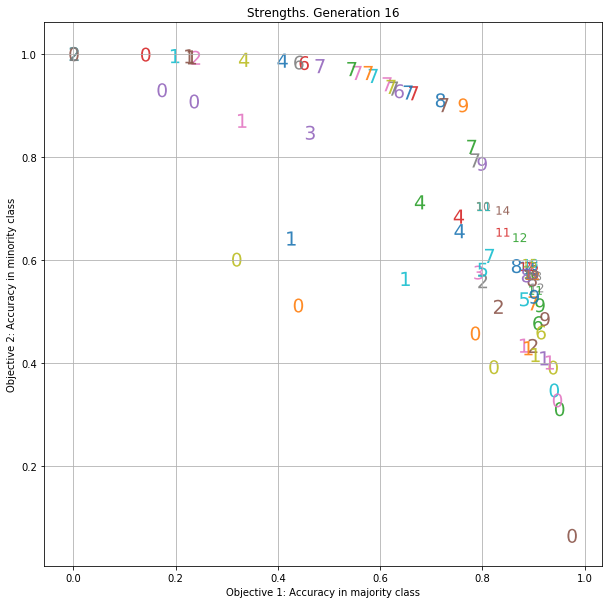

<Figure size 432x288 with 0 Axes>

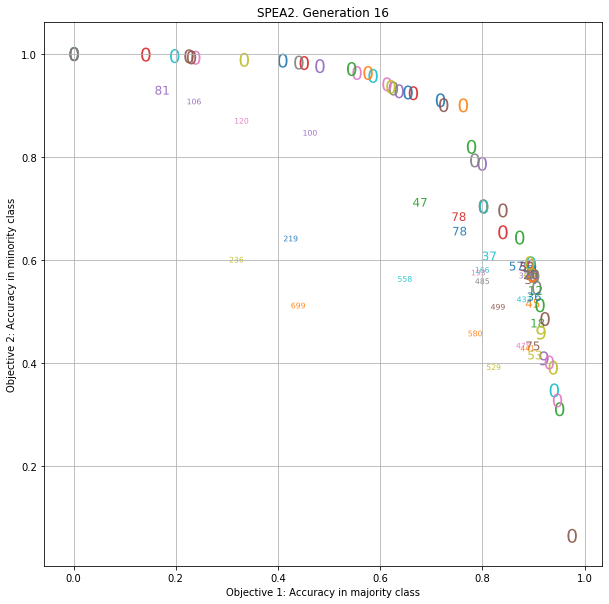

<Figure size 432x288 with 0 Axes>

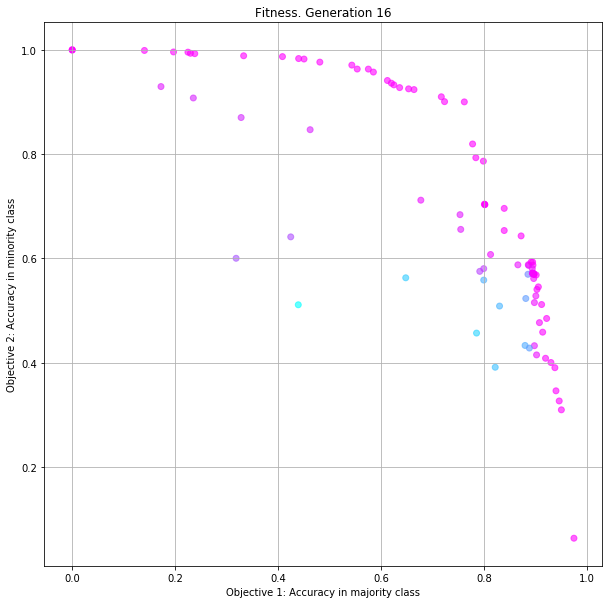

<Figure size 432x288 with 0 Axes>

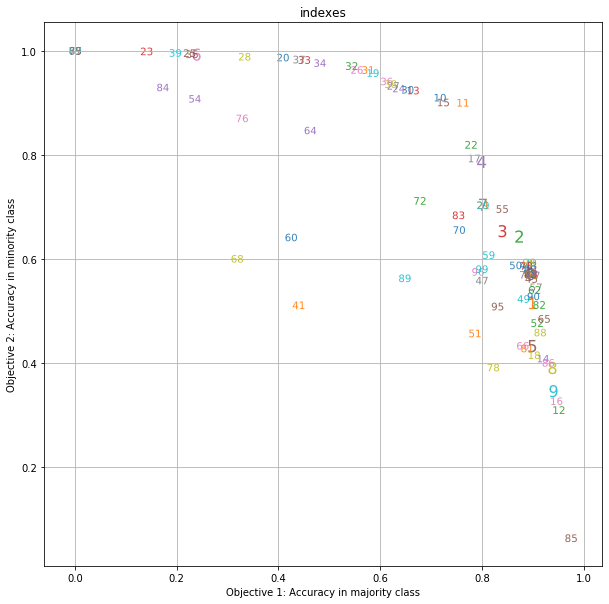

<Figure size 432x288 with 0 Axes>

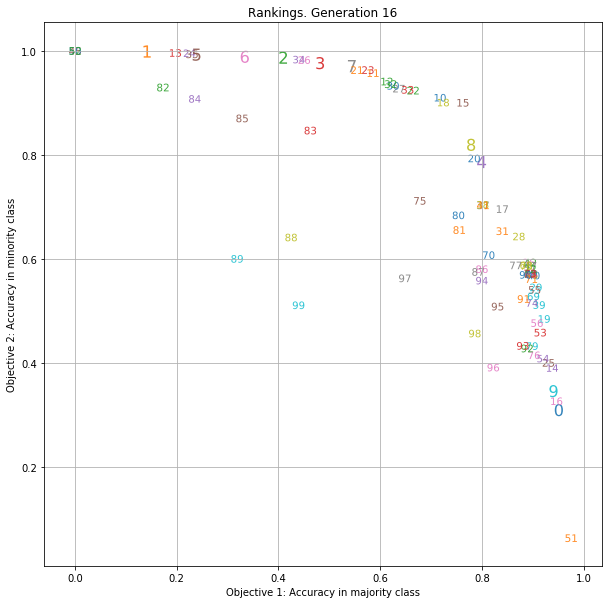

generation: 17


<Figure size 432x288 with 0 Axes>

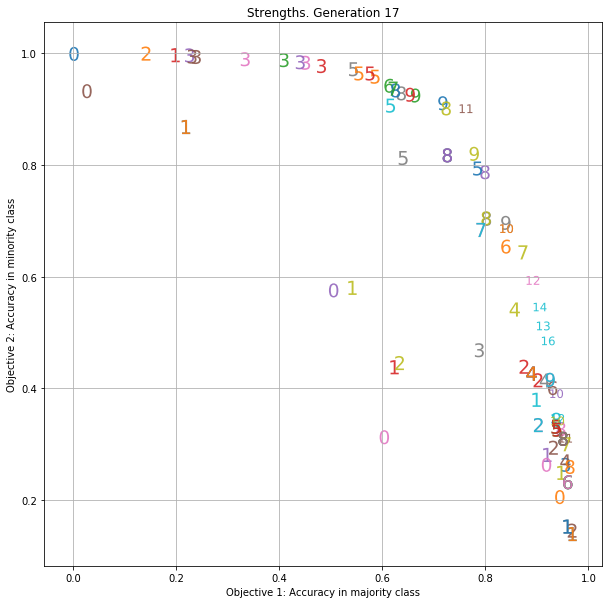

<Figure size 432x288 with 0 Axes>

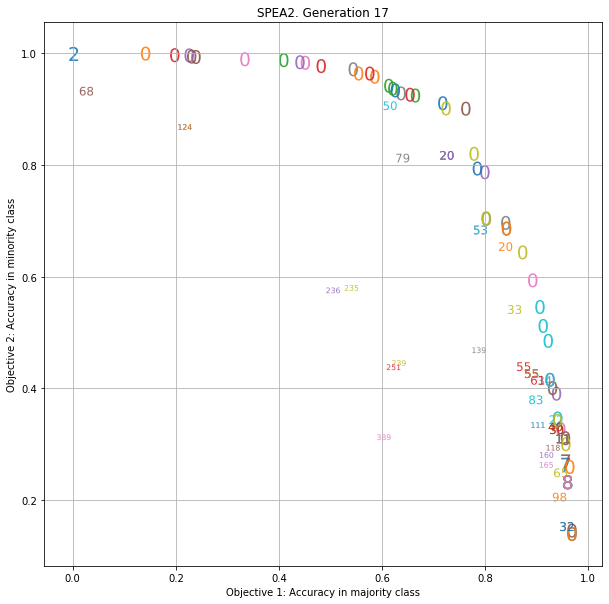

<Figure size 432x288 with 0 Axes>

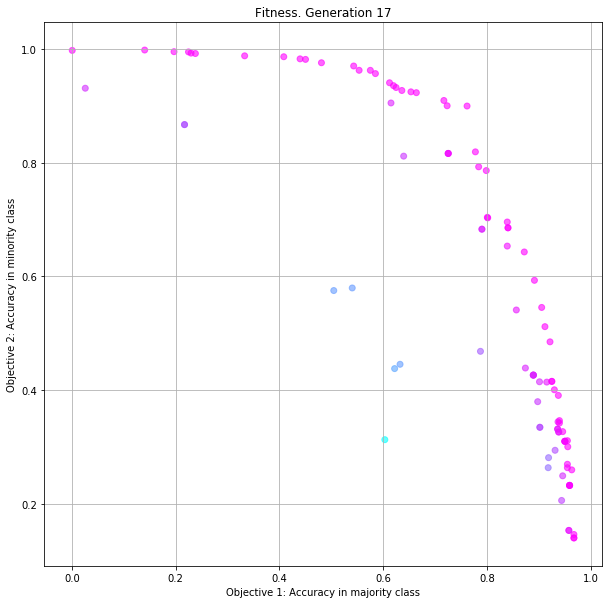

<Figure size 432x288 with 0 Axes>

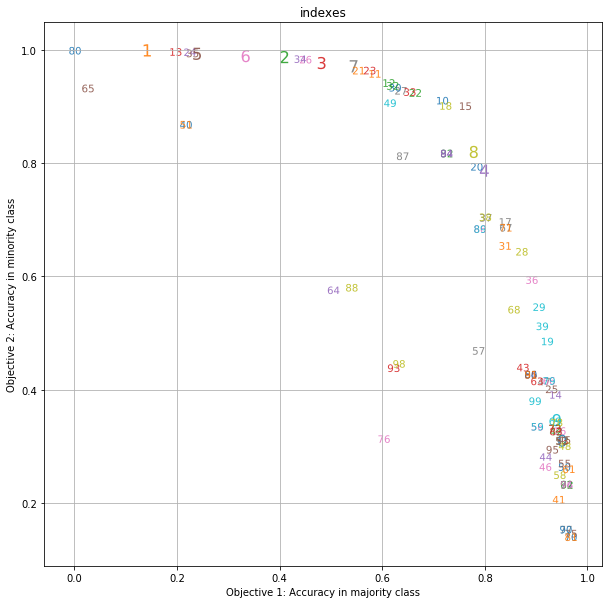

<Figure size 432x288 with 0 Axes>

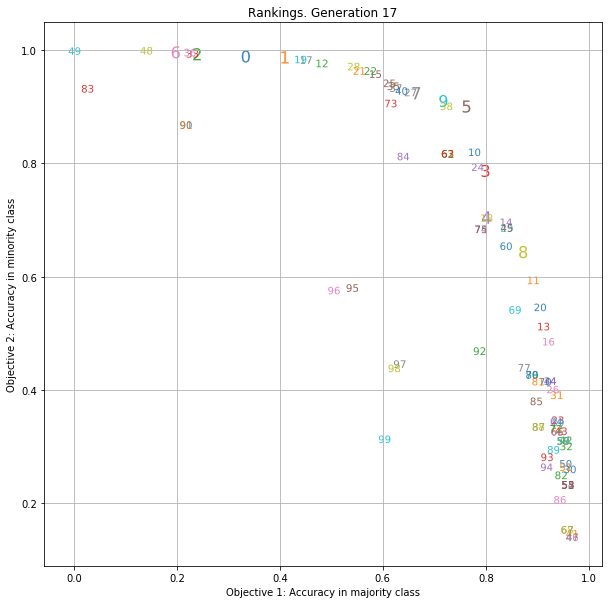

generation: 18


<Figure size 432x288 with 0 Axes>

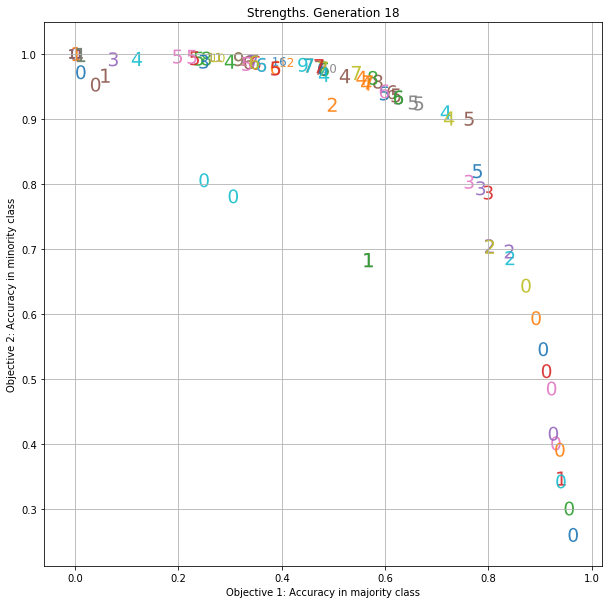

<Figure size 432x288 with 0 Axes>

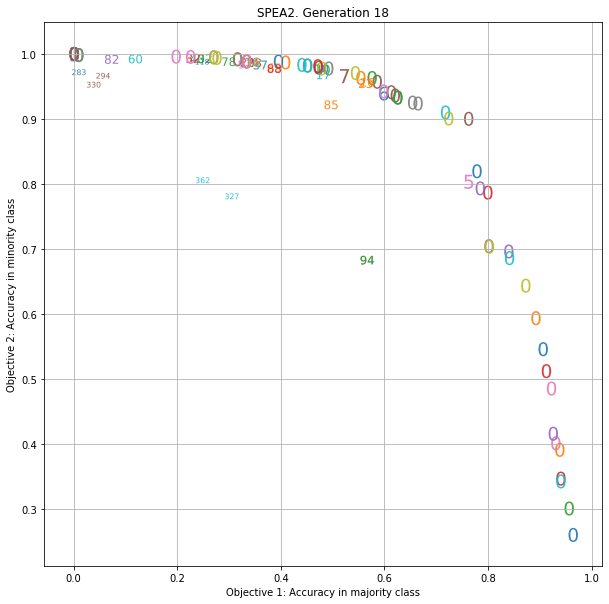

<Figure size 432x288 with 0 Axes>

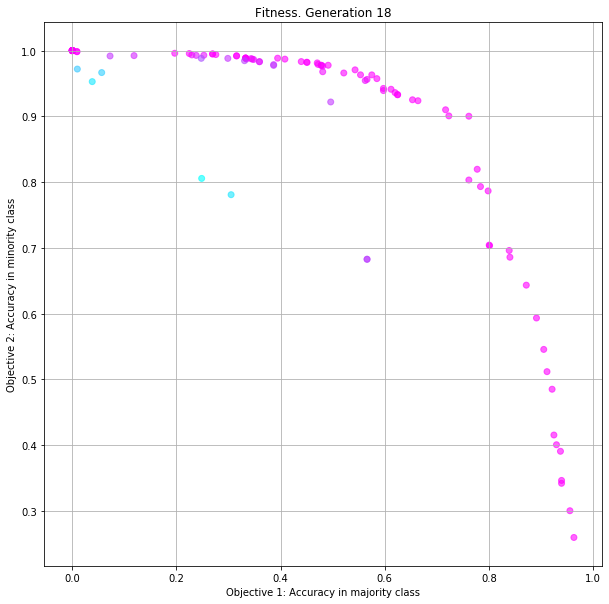

<Figure size 432x288 with 0 Axes>

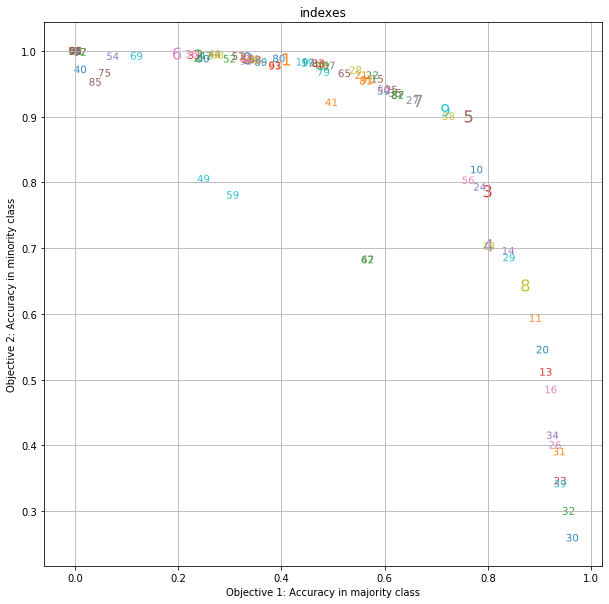

<Figure size 432x288 with 0 Axes>

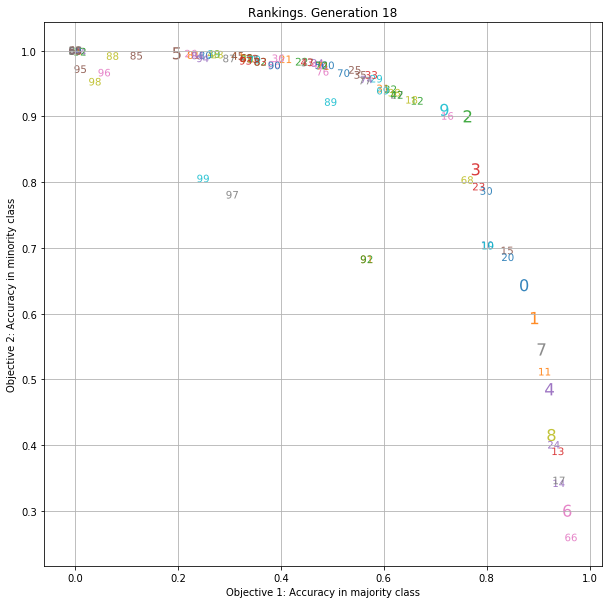

generation: 19


<Figure size 432x288 with 0 Axes>

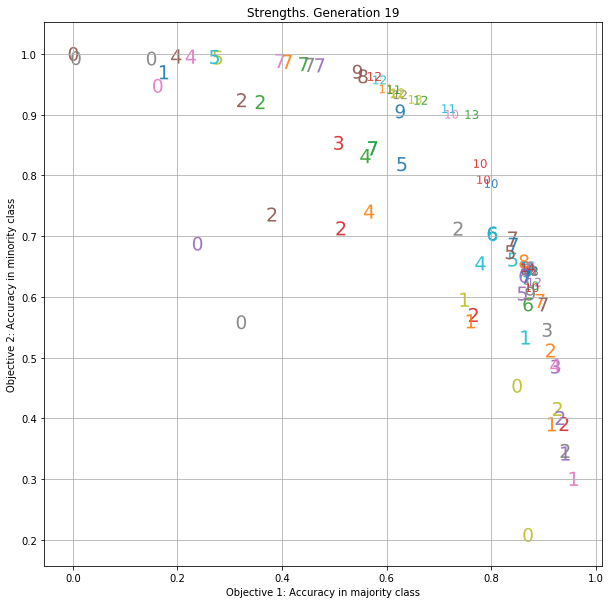

<Figure size 432x288 with 0 Axes>

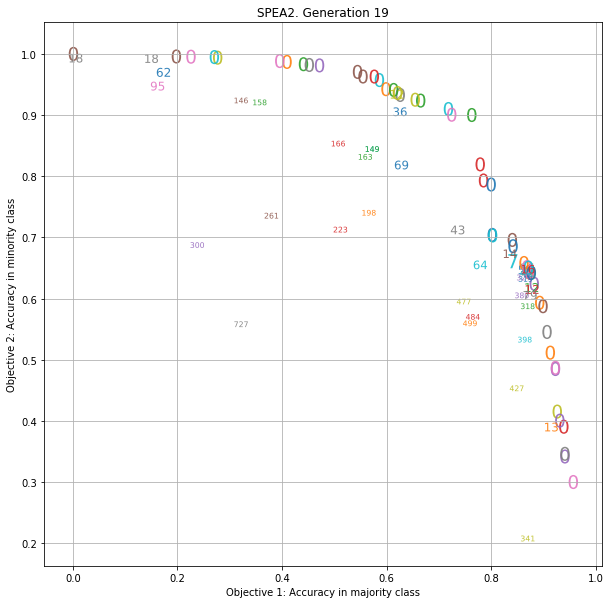

<Figure size 432x288 with 0 Axes>

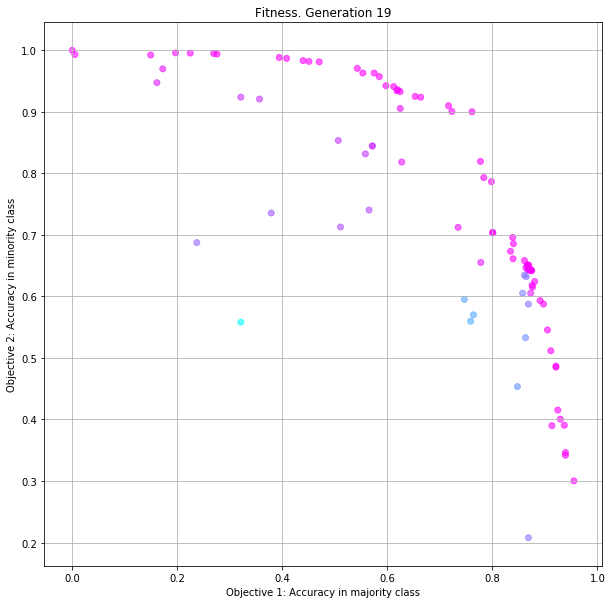

<Figure size 432x288 with 0 Axes>

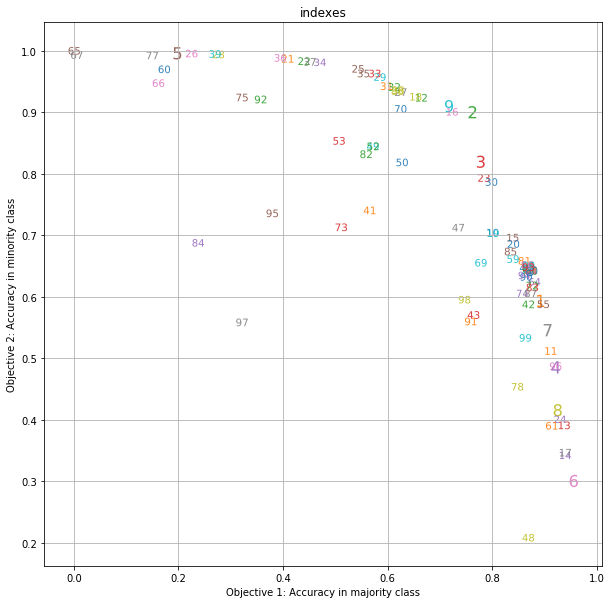

<Figure size 432x288 with 0 Axes>

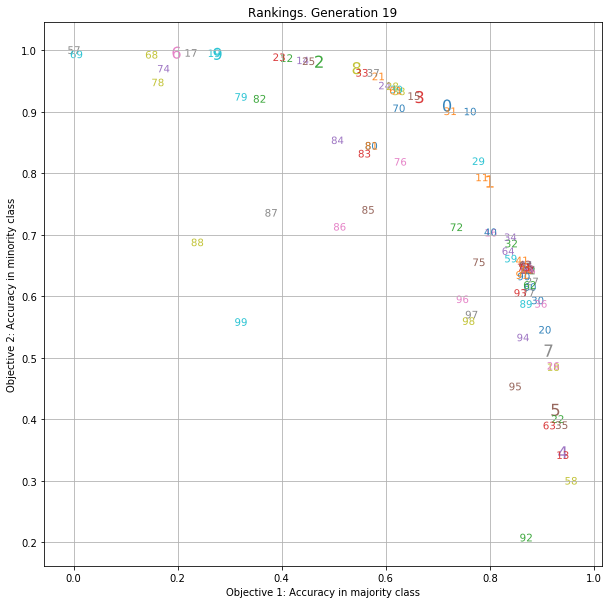

generation: 20


<Figure size 432x288 with 0 Axes>

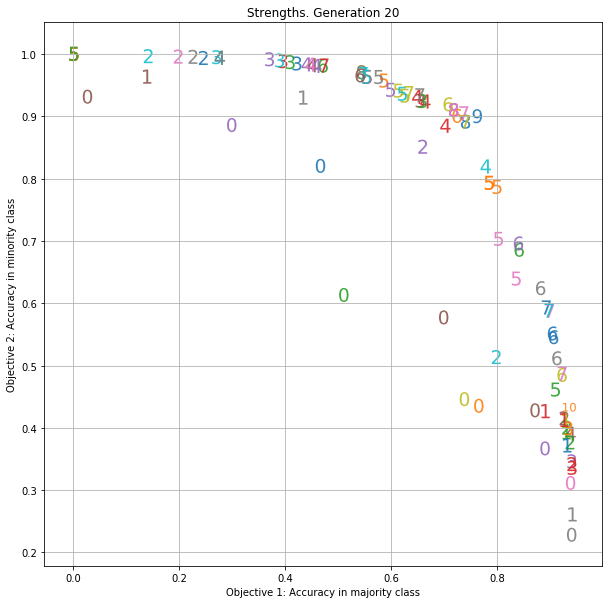

<Figure size 432x288 with 0 Axes>

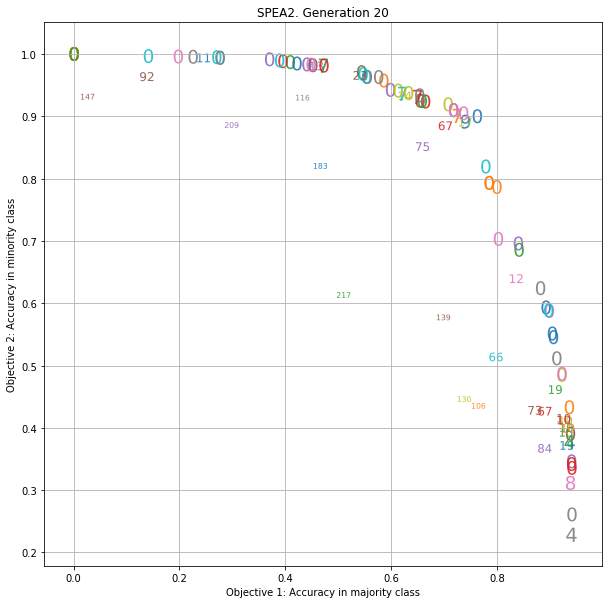

<Figure size 432x288 with 0 Axes>

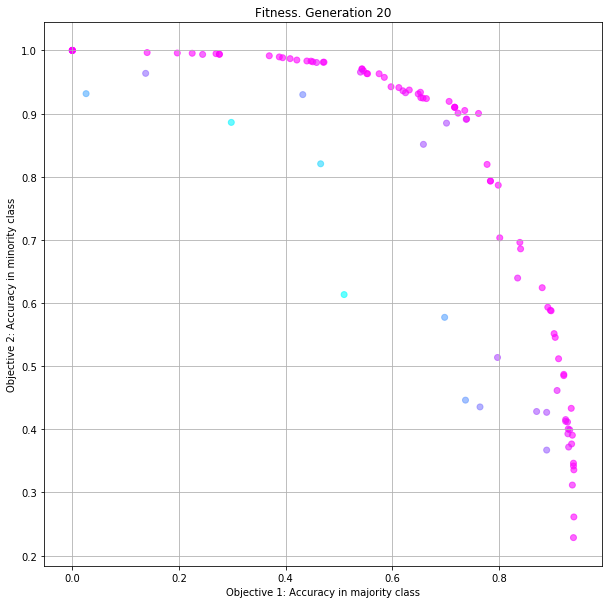

<Figure size 432x288 with 0 Axes>

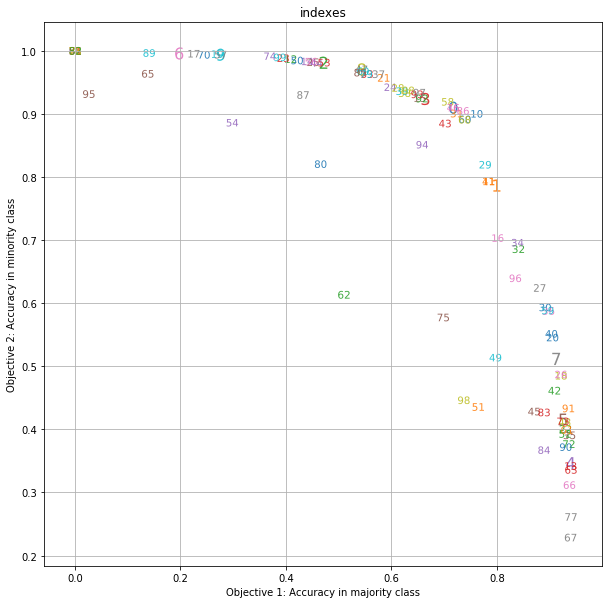

<Figure size 432x288 with 0 Axes>

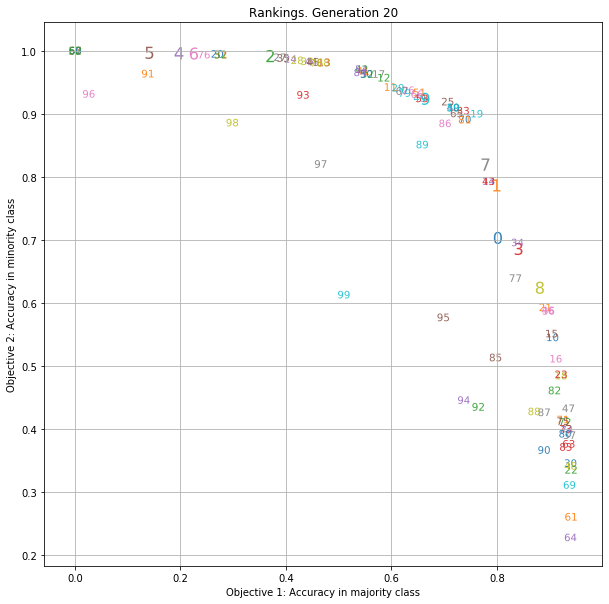

generation: 21


<Figure size 432x288 with 0 Axes>

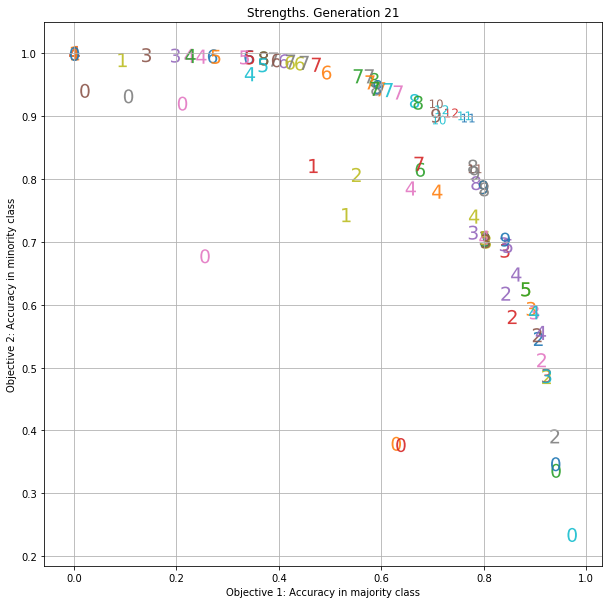

<Figure size 432x288 with 0 Axes>

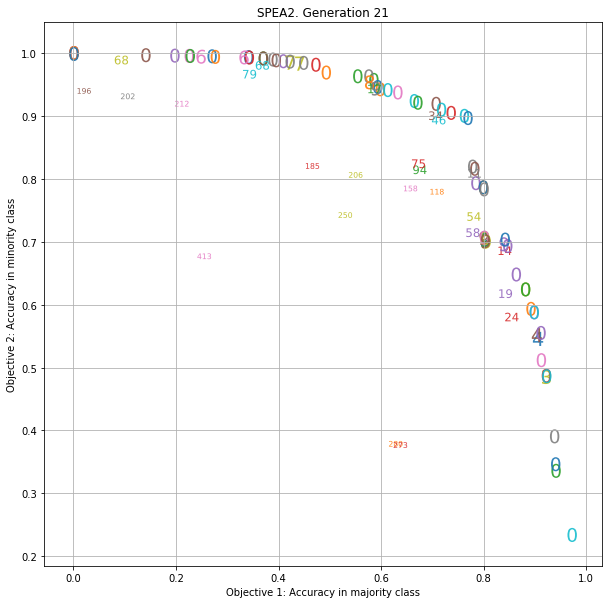

<Figure size 432x288 with 0 Axes>

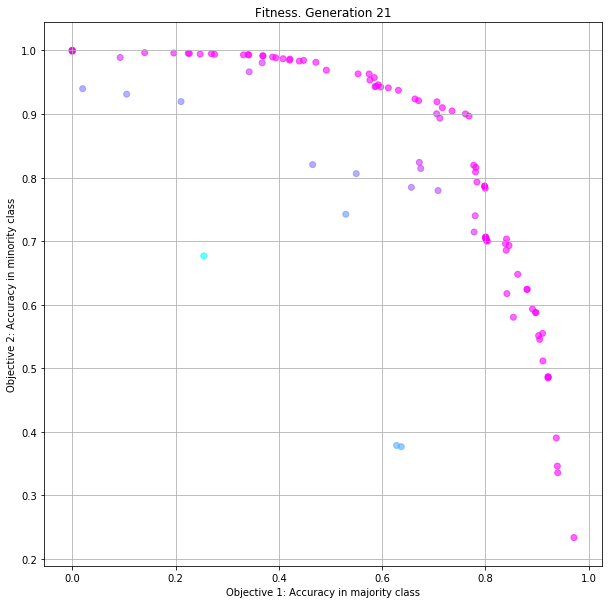

<Figure size 432x288 with 0 Axes>

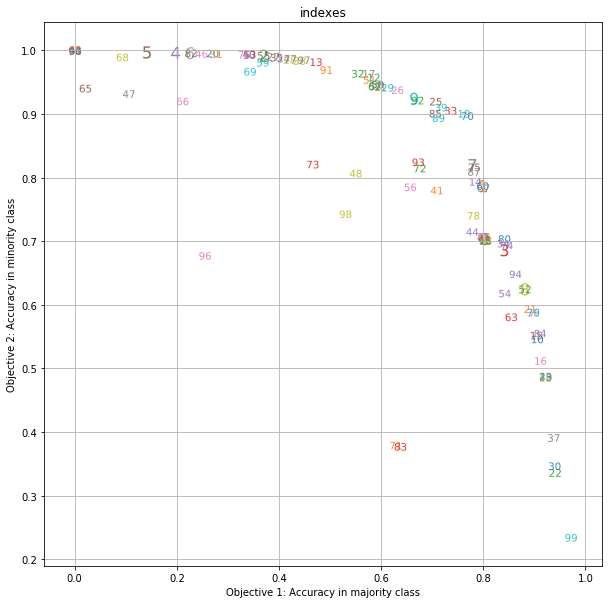

<Figure size 432x288 with 0 Axes>

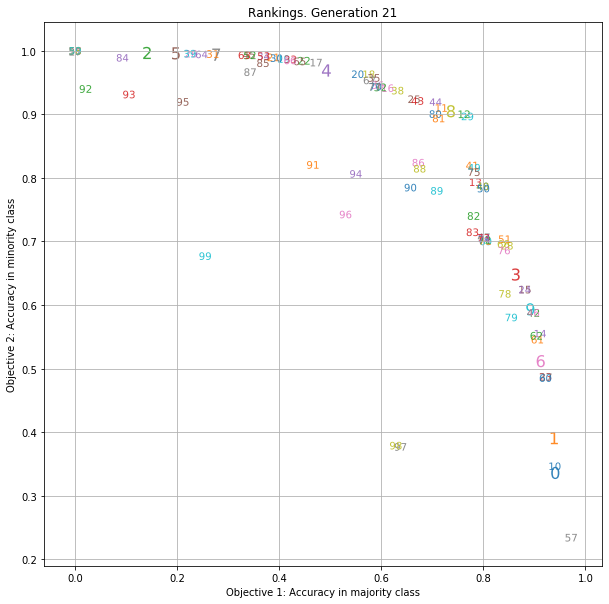

generation: 22


<Figure size 432x288 with 0 Axes>

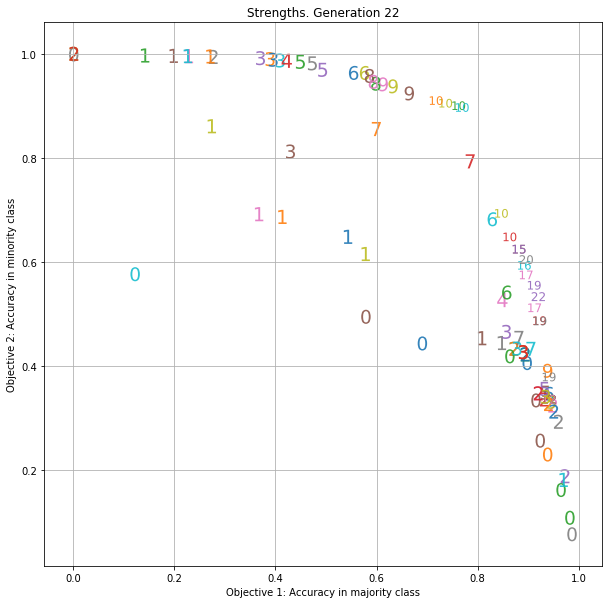

<Figure size 432x288 with 0 Axes>

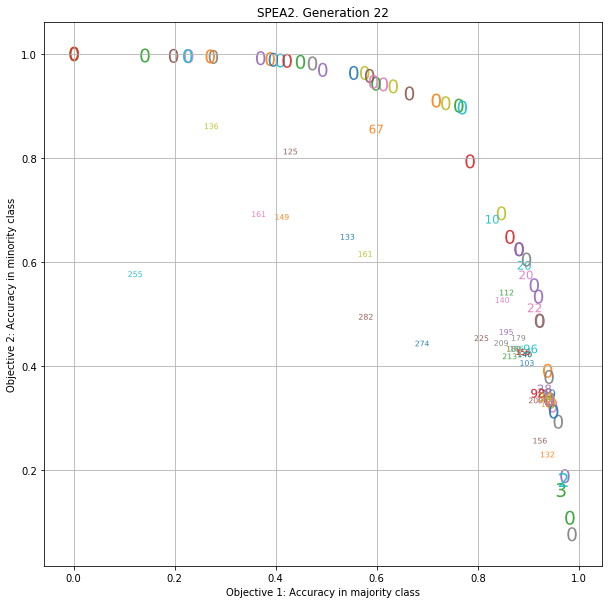

<Figure size 432x288 with 0 Axes>

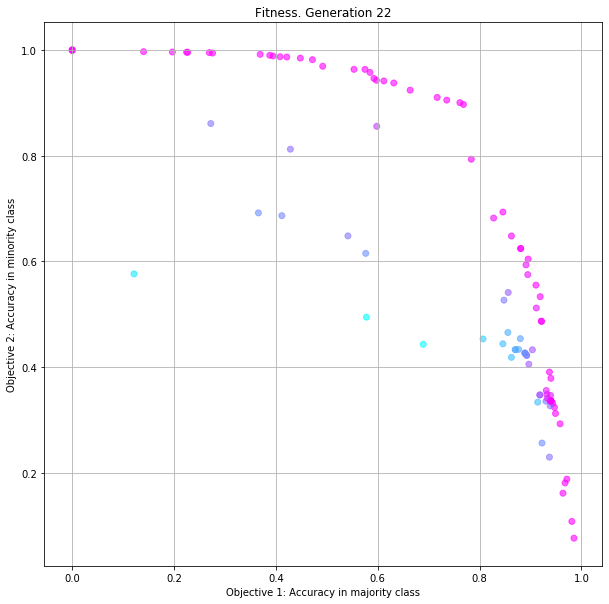

<Figure size 432x288 with 0 Axes>

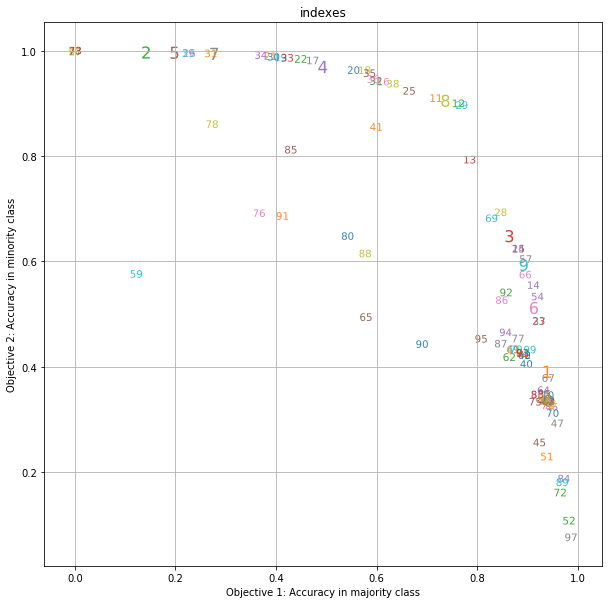

<Figure size 432x288 with 0 Axes>

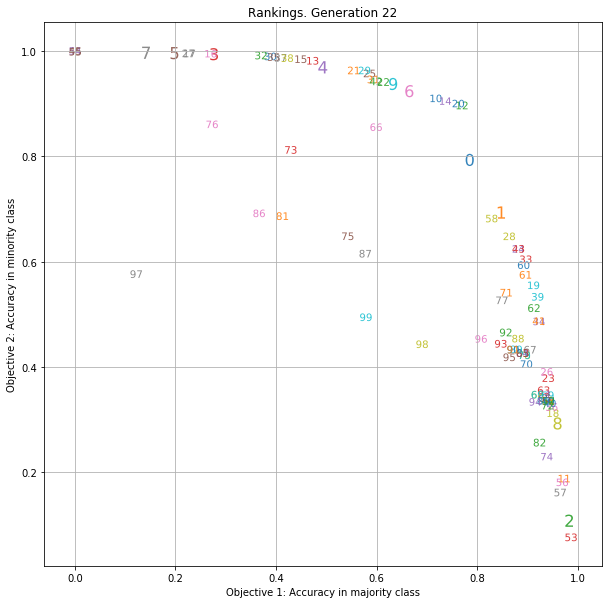

generation: 23


<Figure size 432x288 with 0 Axes>

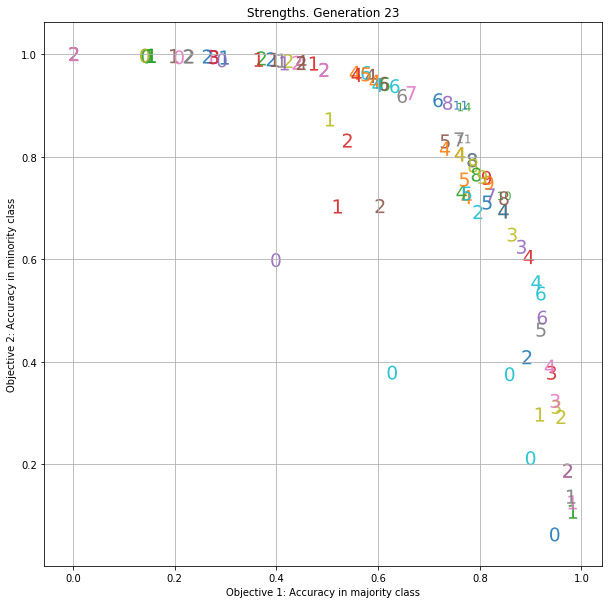

<Figure size 432x288 with 0 Axes>

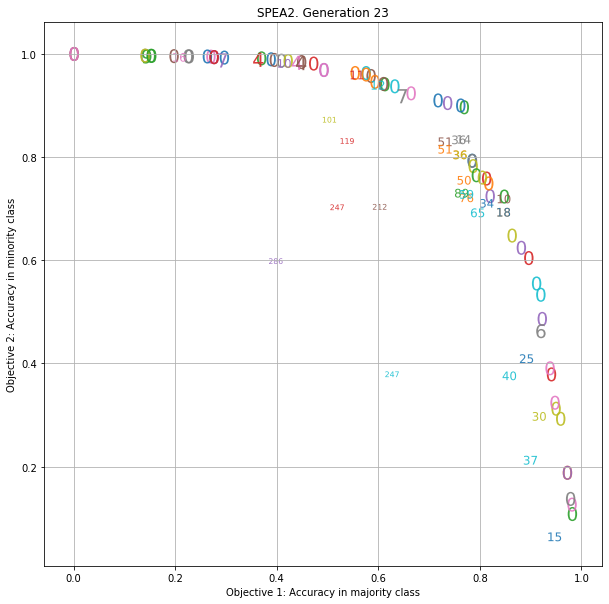

<Figure size 432x288 with 0 Axes>

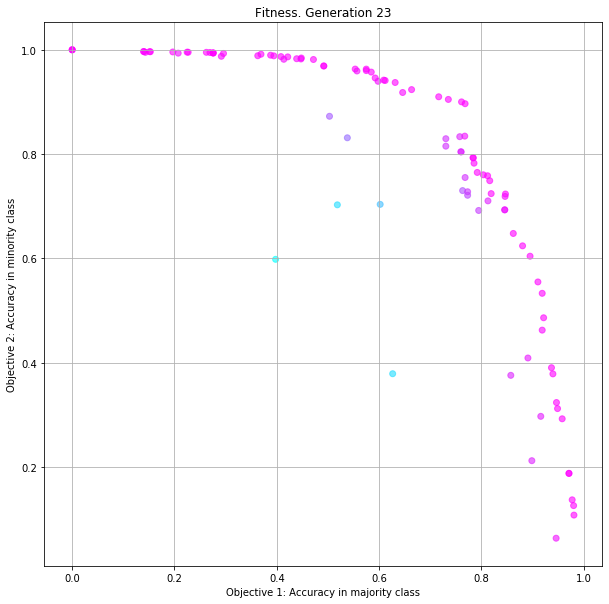

<Figure size 432x288 with 0 Axes>

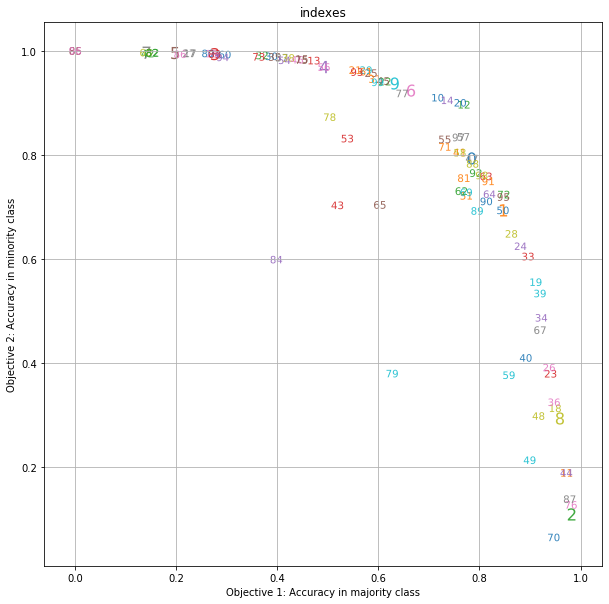

<Figure size 432x288 with 0 Axes>

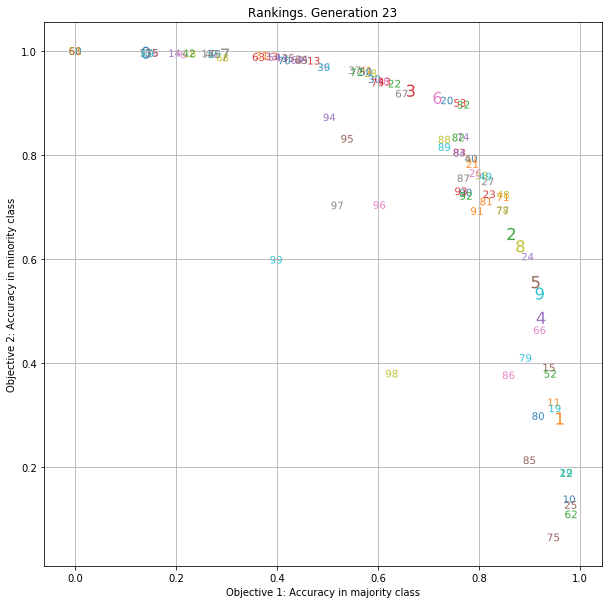

generation: 24


<Figure size 432x288 with 0 Axes>

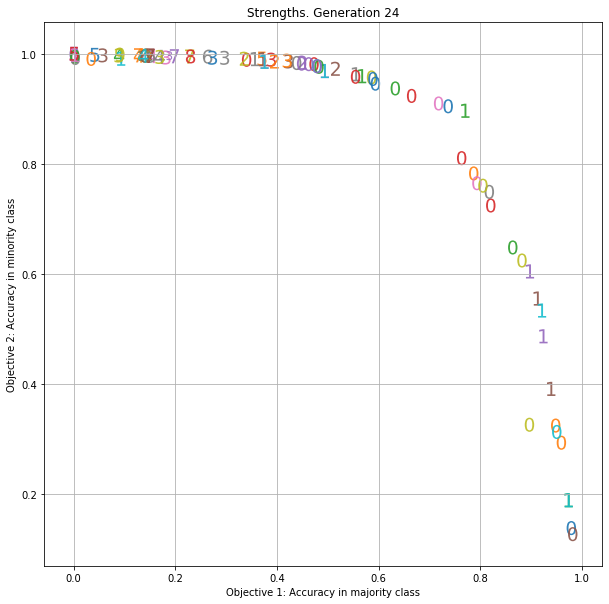

<Figure size 432x288 with 0 Axes>

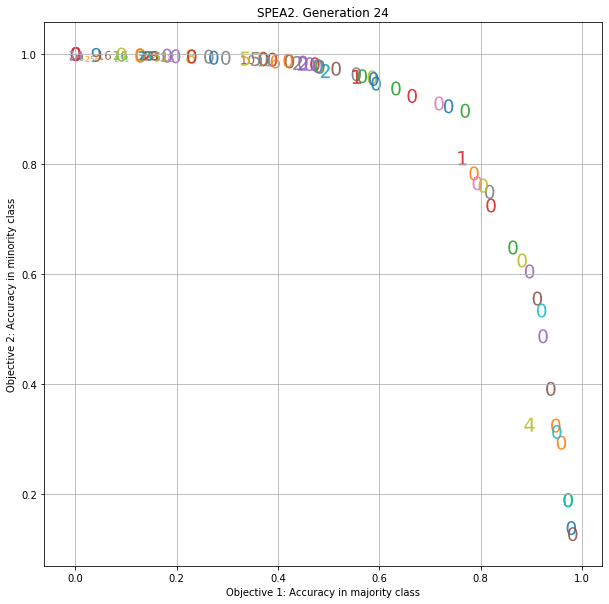

<Figure size 432x288 with 0 Axes>

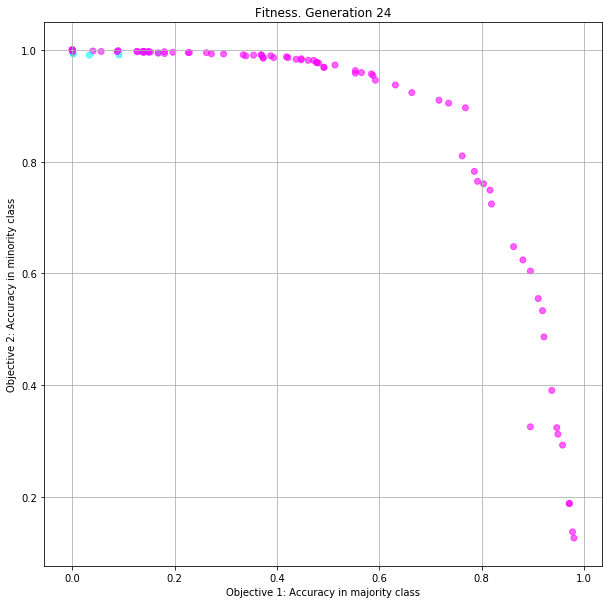

<Figure size 432x288 with 0 Axes>

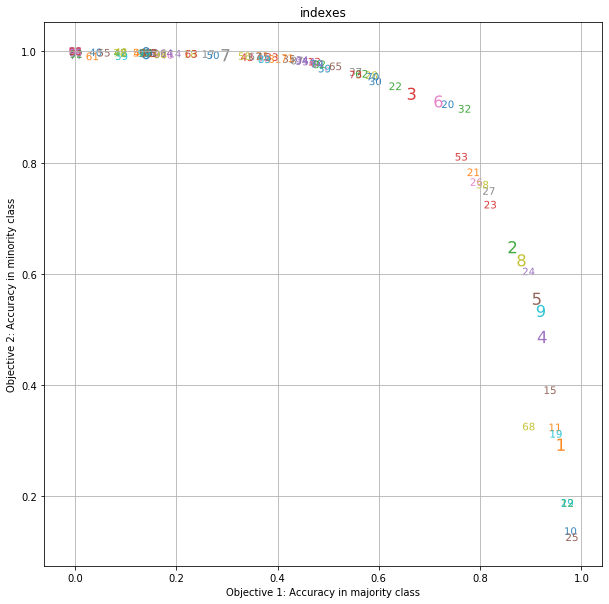

<Figure size 432x288 with 0 Axes>

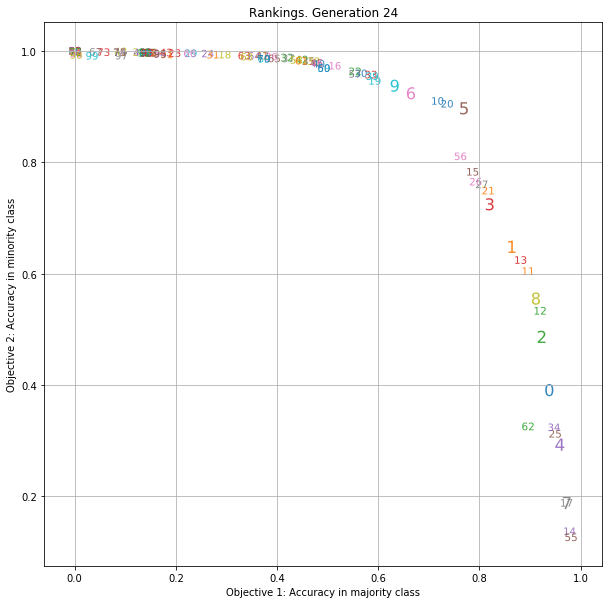

generation: 25


<Figure size 432x288 with 0 Axes>

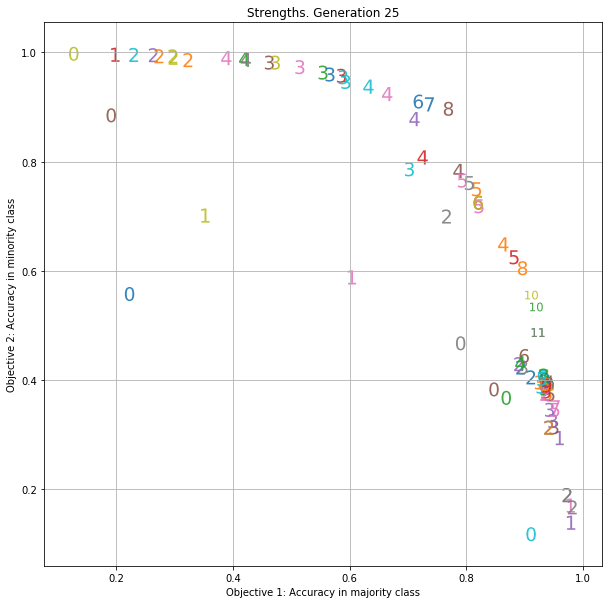

<Figure size 432x288 with 0 Axes>

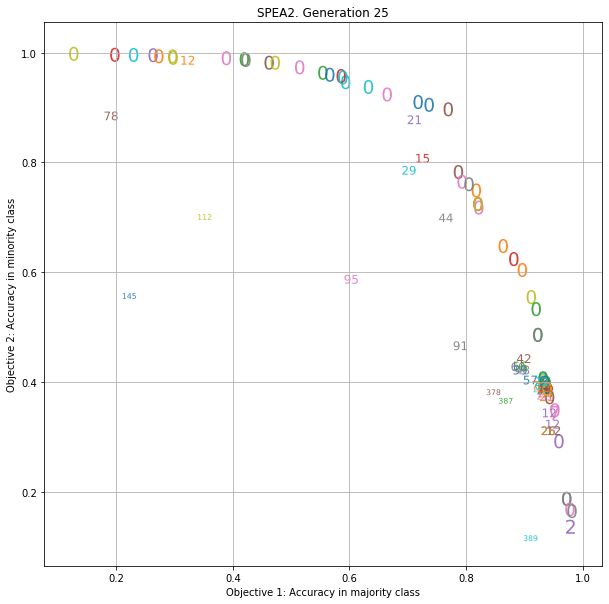

<Figure size 432x288 with 0 Axes>

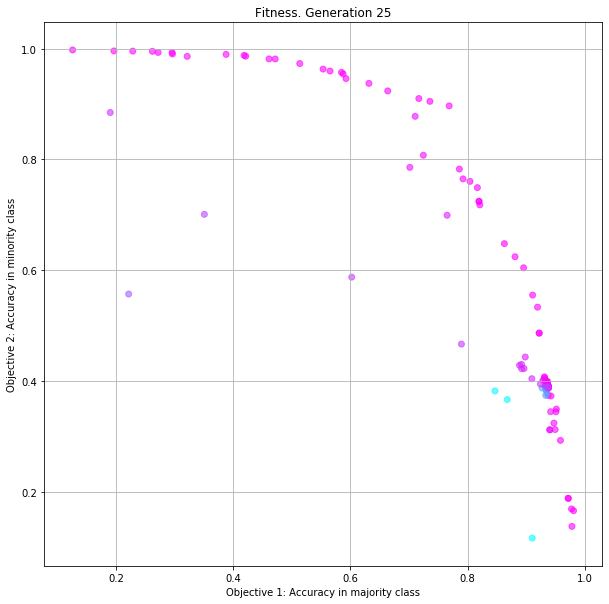

<Figure size 432x288 with 0 Axes>

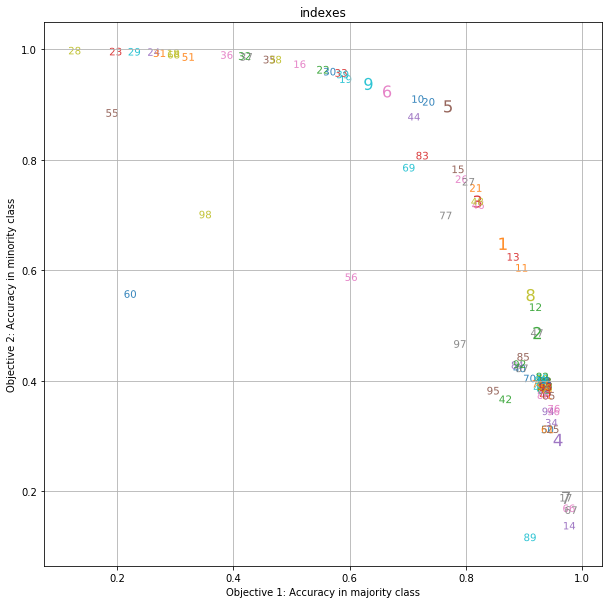

<Figure size 432x288 with 0 Axes>

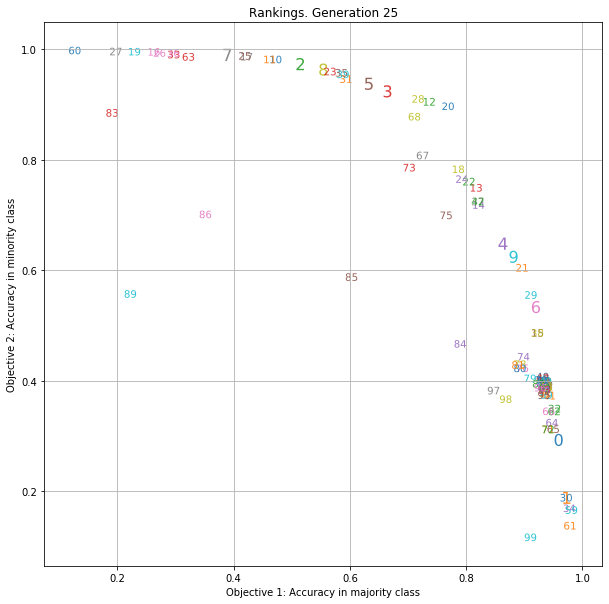

generation: 26


<Figure size 432x288 with 0 Axes>

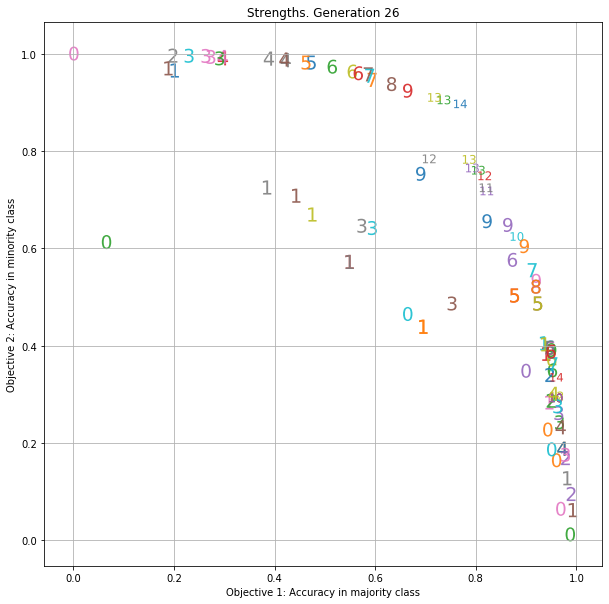

<Figure size 432x288 with 0 Axes>

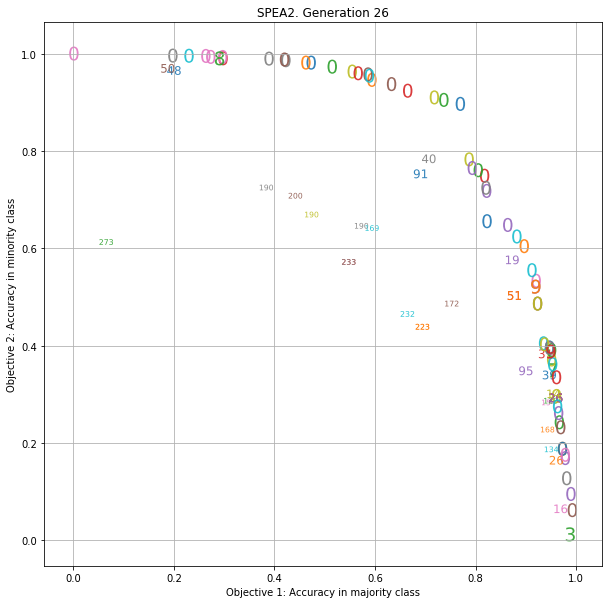

<Figure size 432x288 with 0 Axes>

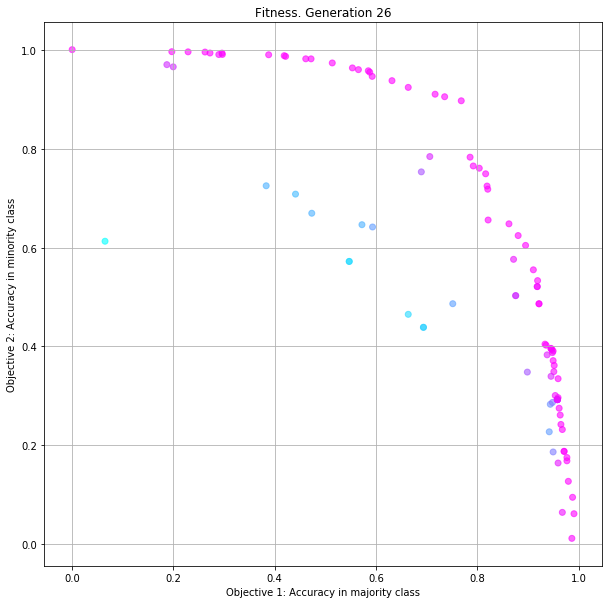

<Figure size 432x288 with 0 Axes>

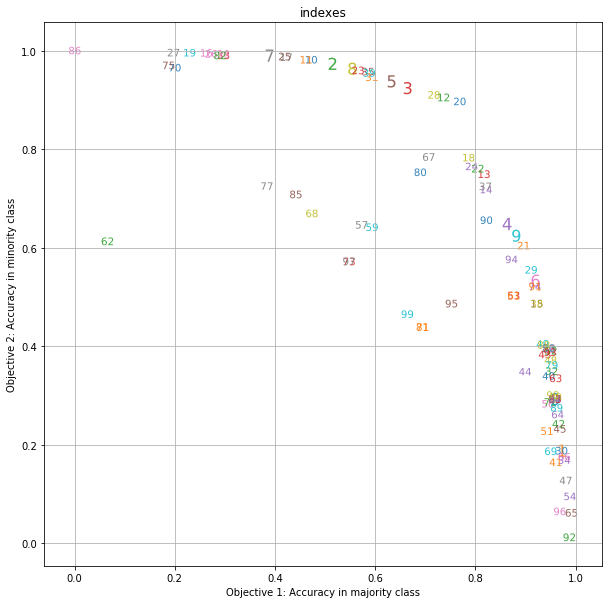

<Figure size 432x288 with 0 Axes>

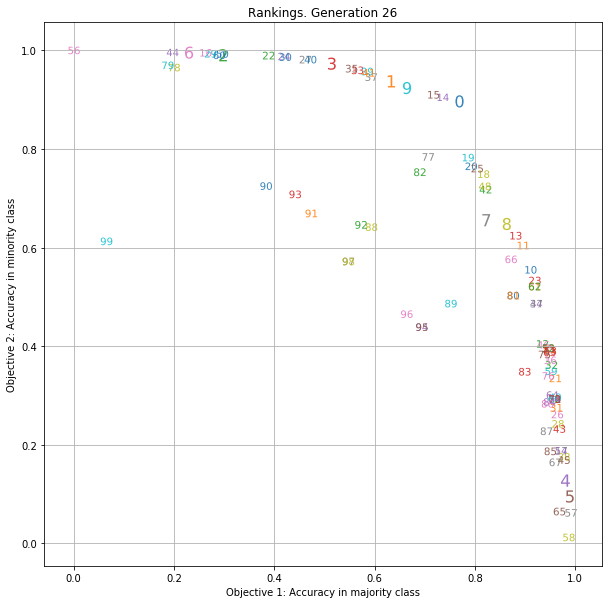

generation: 27


<Figure size 432x288 with 0 Axes>

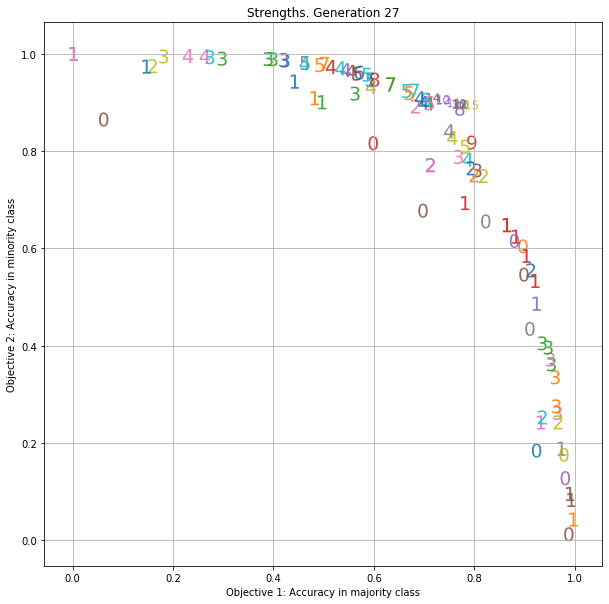

<Figure size 432x288 with 0 Axes>

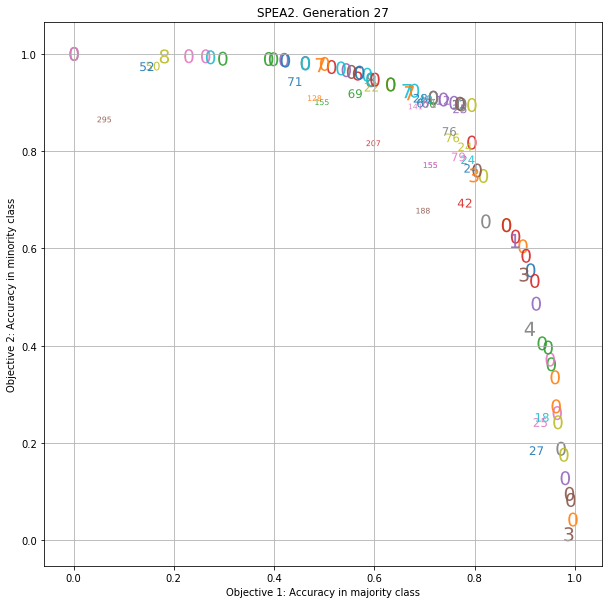

<Figure size 432x288 with 0 Axes>

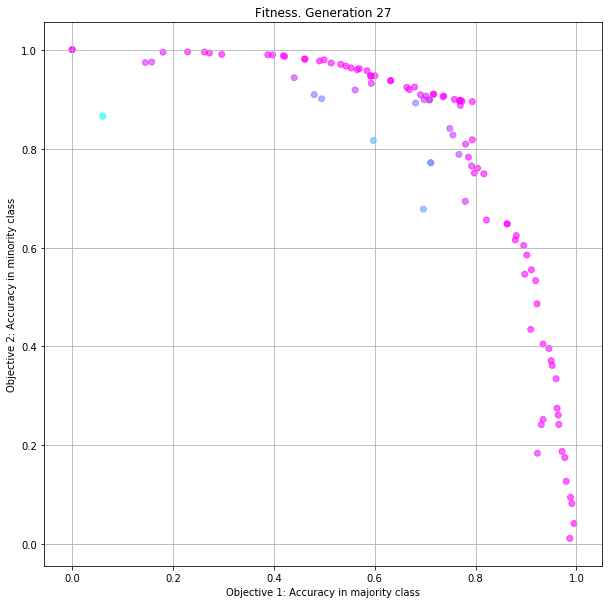

<Figure size 432x288 with 0 Axes>

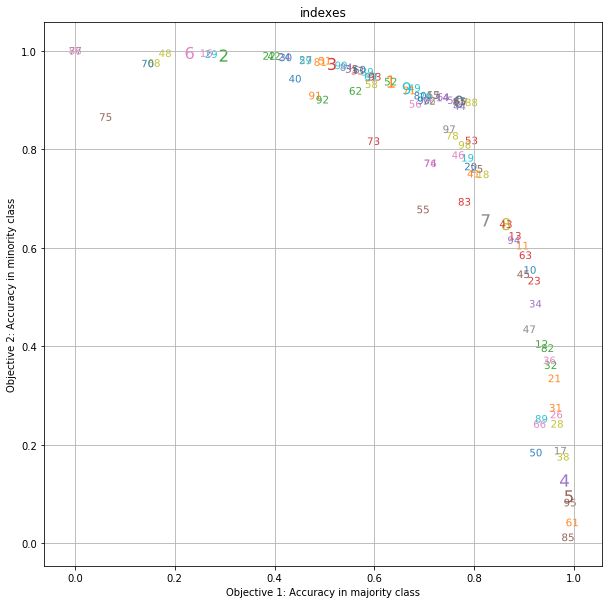

<Figure size 432x288 with 0 Axes>

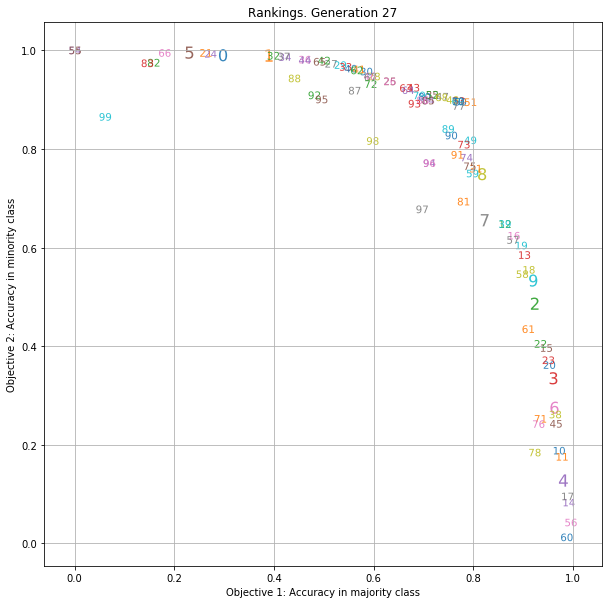

generation: 28


<Figure size 432x288 with 0 Axes>

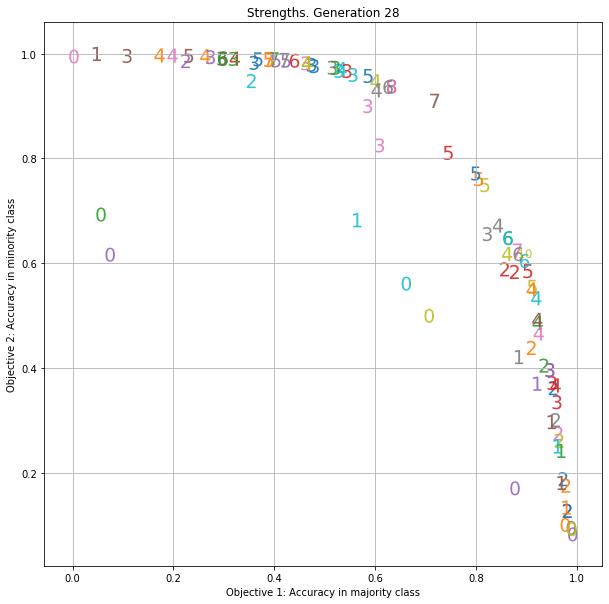

<Figure size 432x288 with 0 Axes>

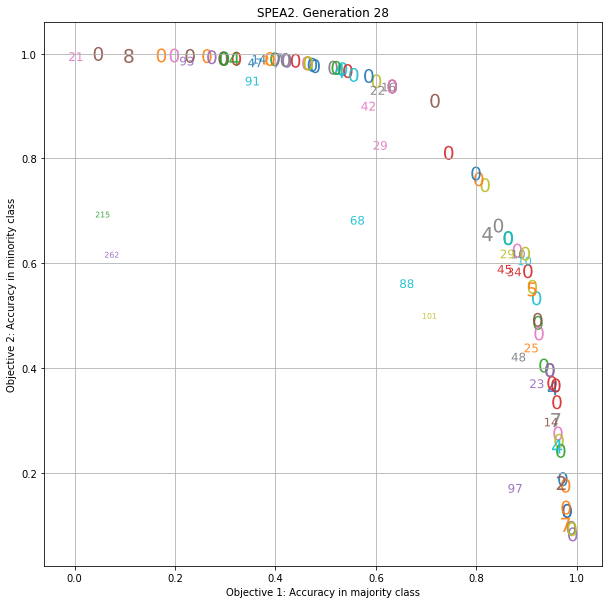

<Figure size 432x288 with 0 Axes>

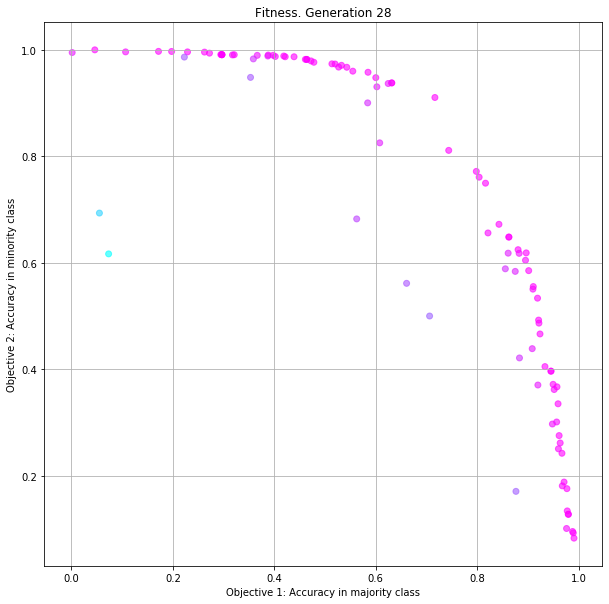

<Figure size 432x288 with 0 Axes>

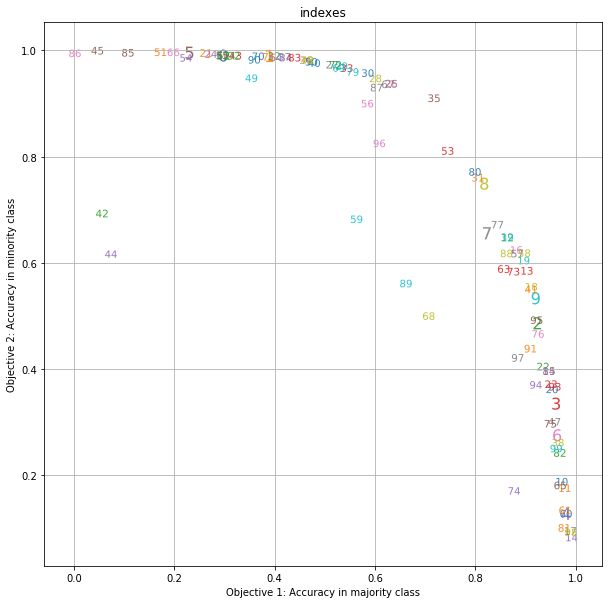

<Figure size 432x288 with 0 Axes>

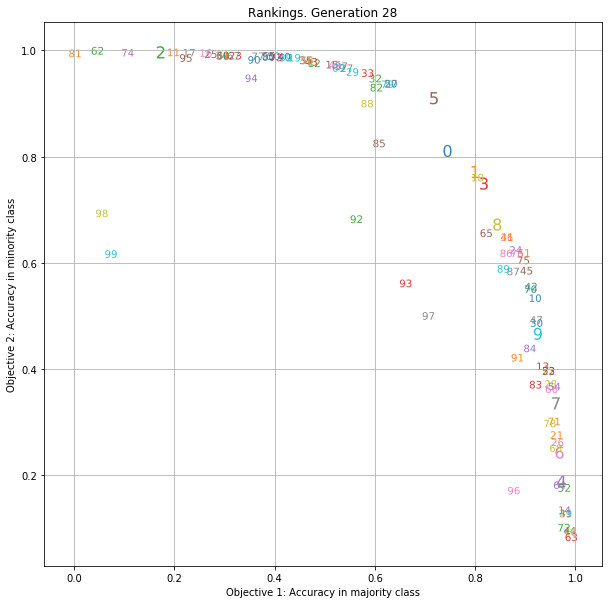

generation: 29


<Figure size 432x288 with 0 Axes>

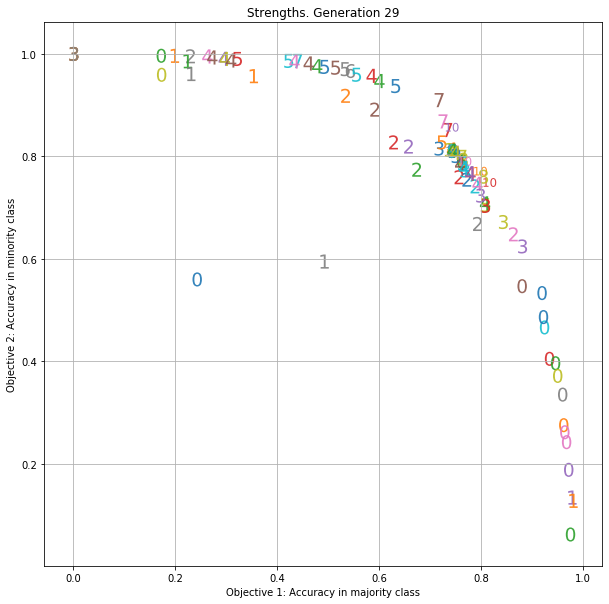

<Figure size 432x288 with 0 Axes>

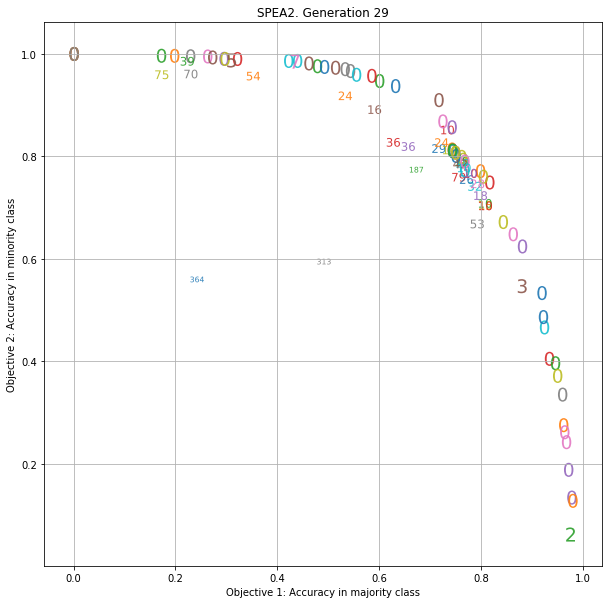

<Figure size 432x288 with 0 Axes>

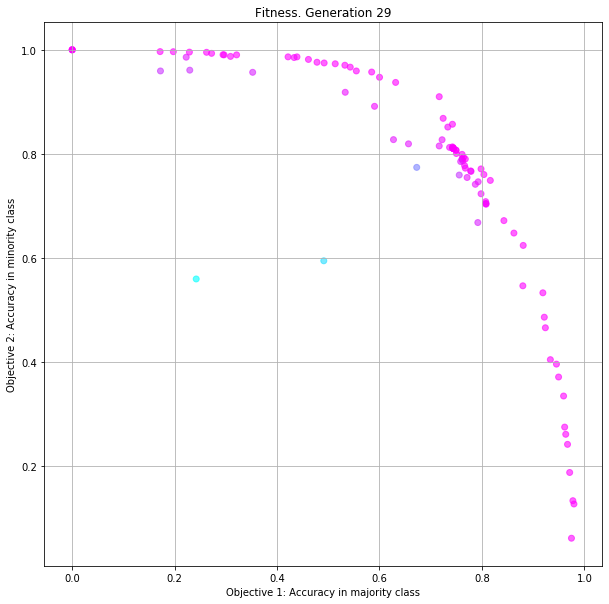

<Figure size 432x288 with 0 Axes>

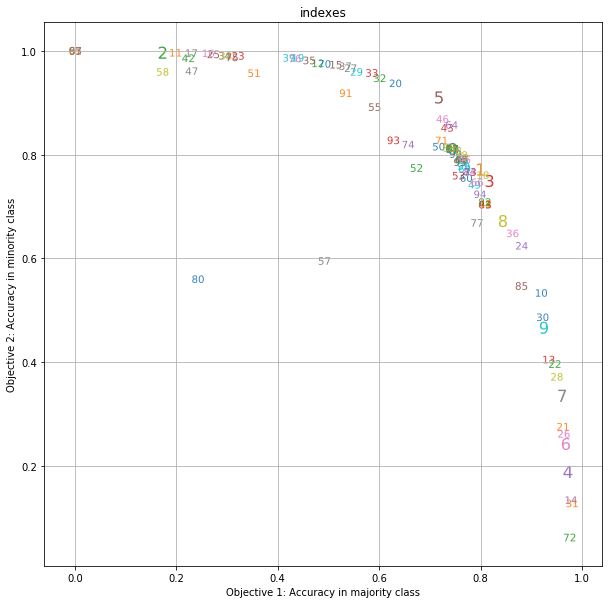

<Figure size 432x288 with 0 Axes>

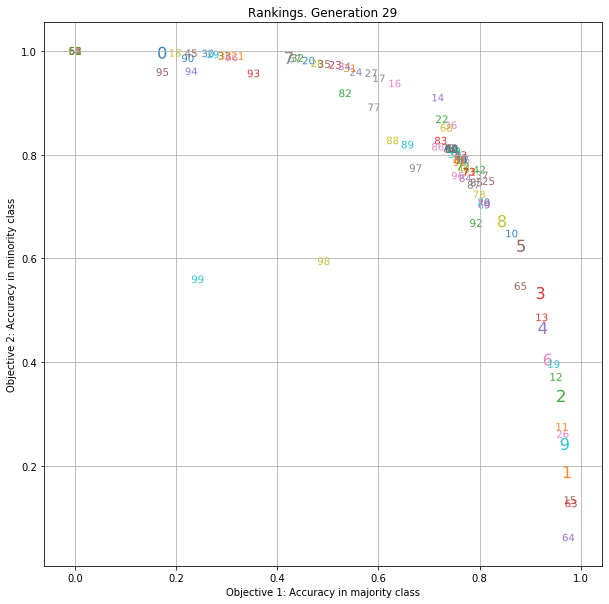

<Figure size 432x288 with 0 Axes>

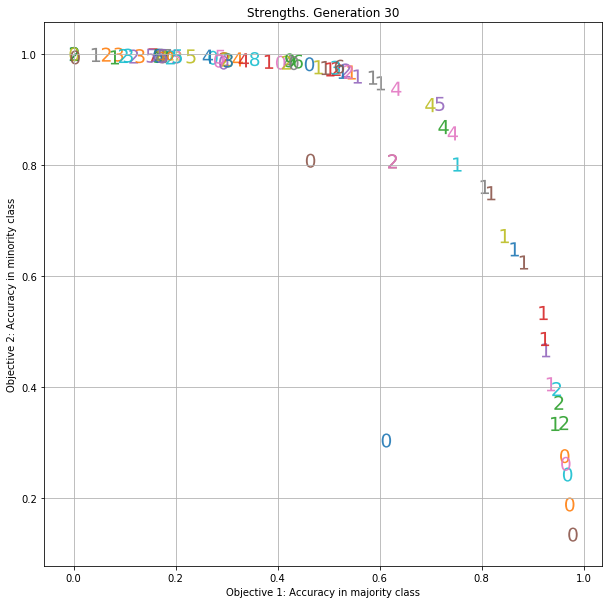

<Figure size 432x288 with 0 Axes>

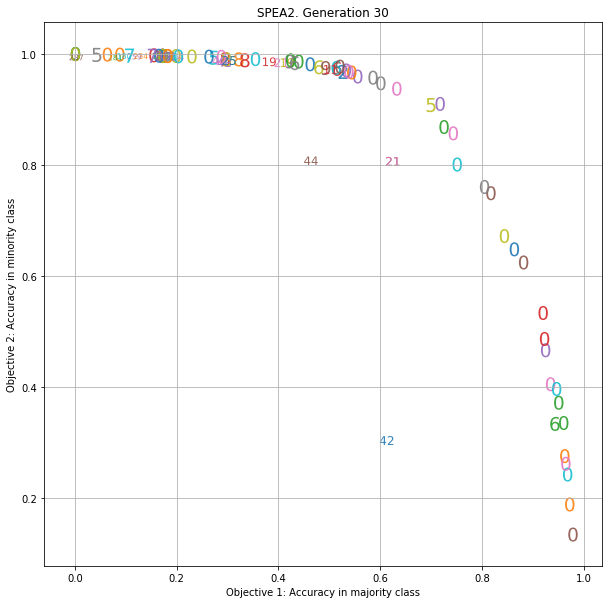

<Figure size 432x288 with 0 Axes>

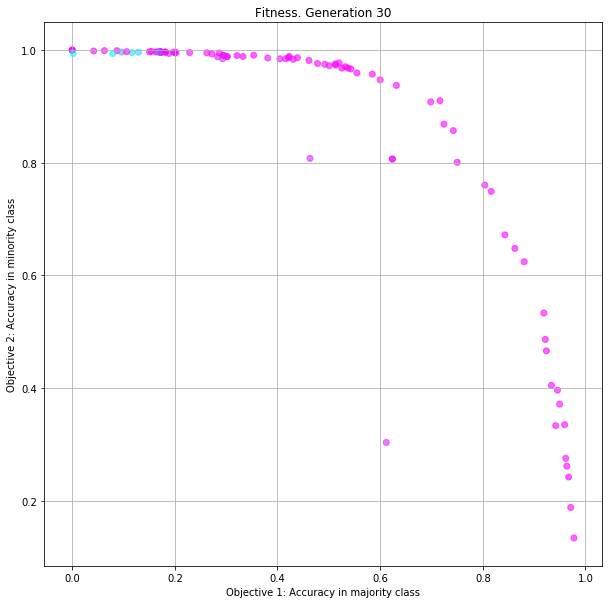

<Figure size 432x288 with 0 Axes>

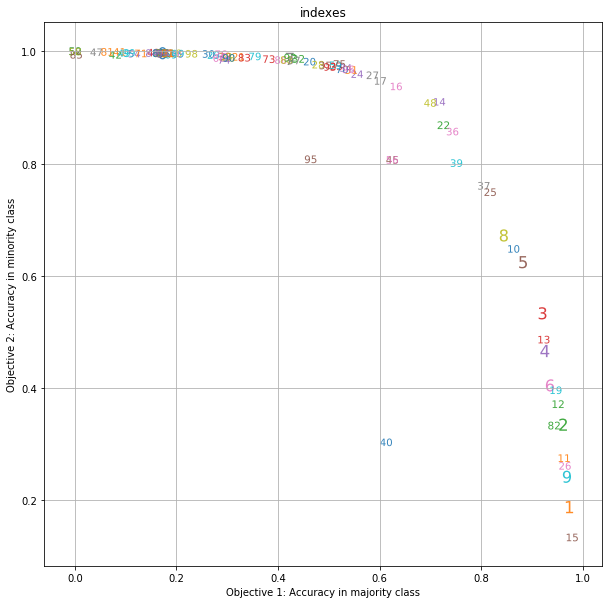

<Figure size 432x288 with 0 Axes>

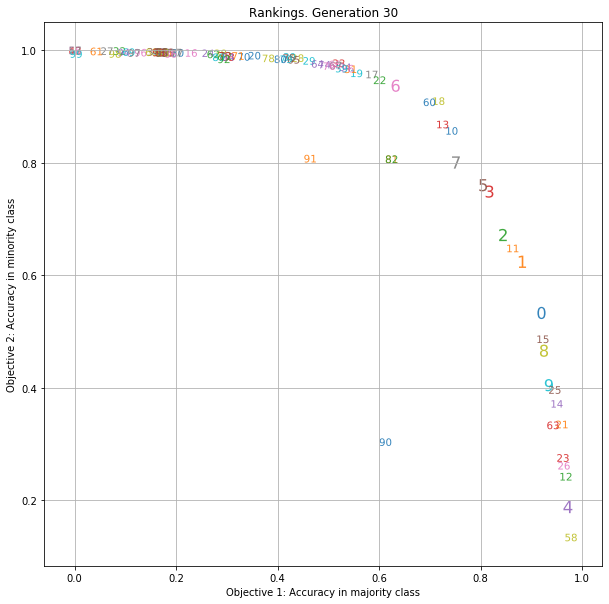

1479.9838500022888


In [10]:
#GP execution
start_time = time.time()
dc = MOGP.fit(Model)
run_time = time.time() - start_time
print(run_time)

In [11]:
#ensemble results test
print("classifiers:",len(MOGP.darwin_champion))

y_evaluations = []
y_evaluation = []

#print(Problem.y[1000])
for individual_classifier in MOGP.darwin_champion:
    y_evaluations.append([1 if Problem.evaluate_tree_image(i,individual_classifier.fenotype) < 0 else 0 for i in range(Problem.data_size)])
    
    #input(str(Problem.evaluate_tree_image(1000,individual_classifier.fenotype)))
y_evaluations = np.array(y_evaluations)
for row in range(Problem.data_size):
    votes = sum(y_evaluations[:,row])
    if votes > len(MOGP.darwin_champion)/2:
        y_evaluation.append(1)
    else:
        y_evaluation.append(0)
        
train_accuracy = sum([1 if y_evaluation[i] == Problem.y[i] else 0 for i in range(Problem.data_size)])/Problem.data_size
Problem.test_mode(True)

y_evaluations = []
y_evaluation = []
for individual_classifier in MOGP.darwin_champion:
    y_evaluations.append([1 if Problem.evaluate_tree_image(i,individual_classifier.fenotype) < 0 else 0 for i in range(Problem.data_size)])
y_evaluations = np.array(y_evaluations)
for row in range(Problem.data_size):
    votes = sum(y_evaluations[:,row])
    if votes > len(MOGP.darwin_champion)/2:
        y_evaluation.append(1)
    else:
        y_evaluation.append(0)

test_accuracy = sum([1 if y_evaluation[i] == Problem.y[i] else 0 for i in range(Problem.data_size)])/Problem.data_size
Problem.test_mode(False)
print("train_accuracy",train_accuracy)
print("test_accuracy",test_accuracy)
    

classifiers: 59
train_accuracy 0.9308571428571428
test_accuracy 0.9314107142857143


In [12]:
from load_pedestrian import load_pedestrian_data
X_train, X_test, y_train, y_test = load_pedestrian_data(base_dir="./data/")

In [13]:
X_train_reshaped = np.array([image.reshape((18,36)) for image in X_train])
X_test_reshaped = np.array([image.reshape((18,36)) for image in X_test])
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train_reshaped[0])

[[121 109  95 100 124 128  83  60  79 171  80  62  65  59  61 159 120 134
  122 107  96  92 123 133  87  61  79 166  75  65  68  61  62 157 118 135]
 [126 110  94  97 130 143  91  62  68  95  74  67  67  55  65 157 118 132
  128 113  92 100 133 141  89  57  62  63  62  67  73  60  63 153 117 133]
 [124 113  91  98 127 137  90  55  63  67  75  65  65  82  73 148 114 129
  125 112  90  94 128 134  87  55  65  79  98  87  84  70  69 143 109 124]
 [125 114  91  95 128 127  87  60  72  83  93  87  76  57  61 140 105 122
  128 117  93  97 131 127  84  79  73  67  82  70  85  79  57 130  97 119]
 [131 117  95  95 134 134  78  68  70  64  68  71  78  87  92 144 112 121
  130 118  94  98 135 139  75  64  67  71  79  78  75  75  89 145 111 116]
 [129 120  92  98  94  68  65  63  70  65  67  72  72  71  84 137 113  93
  128 115  86  67  54  60  54  59  72  71  72  69  75  70  79 114 110  81]
 [126 116  75  53  57  61  70  58  67  73  72  74  72  68  73  82  99  74
  129 114  54  57  47  62  56  5

In [24]:
#Data pre-processing
X_train_features = [feature_extractor(x, box_size = 6, stride =6, ignore_borders = 0) for x in X_train_reshaped]
X_test_features = [feature_extractor(x, box_size = 6, stride =6, ignore_borders = 0) for x in X_test_reshaped]
max_feature = 255
X_train_normalised_features = [x / max_feature for x in X_train_features]
X_test_normalised_features = [x / max_feature for x in X_test_features]

In [25]:
PedestrianProblem = ImageClassificationWithMOGP(X_train_normalised_features,
                                                X_test_normalised_features, 
                                                y_train, 
                                                y_test, 
                                                [1,0])

In [26]:
Model = SymbollicTreeFunction(
    features = PedestrianProblem.dimensions,
    evaluate_fitness_f = PedestrianProblem.evaluate_fitness_SPEA2,
    max_initial_depth = 3,
    )

MOGP_Ped = GeneticAlgorithm(
    population_size = 100, 
    generations = 30, 
    sampling_method = "weighted_random", 
    mutation_ratio = 0.4, 
    elite_ratio = 0.4)

In [ ]:
#GP execution
start_time = time.time()
dc = MOGP_Ped.fit(Model)
run_time = time.time() - start_time
print(run_time)

population_size 100
archive_population_size 40
offspring_population_size 60
samples 0
mutations 24
crossovers 36
generation: 0
